## manning_replication.ipynb

### Before running this code:
- Spikes for each microwire channel were identified and sorted into clusters using the wave_clus package in Matlab.
- LFP data was downsampled from ~32k Hz to 2000 Hz and saved in /data/continuous/**subj**/**session**/lfp/chan.*
- Spikes in each cluster were aligned to the downsampled LFP data and saved as **subj**-**session**-**channel**.mat files in /data3/scratch/dscho/frLfp/data/ucla/**subj**/**session**. This was done by dan_fl_alignSpikes.m, a Matlab script that I modified from Ashwin's fl_alignSpikes.m code in his svn repository (/home1/svn/AshwinCode_post_phd). This Matlab script and its dependencies are stored on my Google Drive for now, but eventually I'll upload them to rhino.

### Preprocessing Steps:
- Loads metadata (for all channels across subjects and recording sessions) into a pandas DataFrame.
- Loads 2000 Hz LFP and aligned spike data for all microwire channels from a selected recording session.
- Computes smoothed firing rate for each timepoint (and for each unit, channel in the session) by convolving spike train data with a Gaussian kernel (half-width: 500 ms).
- Removes spikes from each LFP channel by linear interpolation (-2 to 8 ms surrounding each spike).
- Combines LFP data across channels (in a single recording session) into an mne RawArray.
- Using mne, applies a notch filter to all LFP channels at 60, 120, and 180 Hz to remove line noise.
- Creates a ptsa TimeSeries representation of the RawArray and saves preprocessed LFP data for all channels in the session as an hdf5 file.
- Saves preprocessed spike data for all channels in the session as a pickle object.

### Processing Steps:
- Using ptsa, applies a Morlet transform (wave length 4) to preprocessed LFP data at 50 log-spaced frequencies from 2 to 150 Hz, returning power and phase at each timepoint.
- Log-transforms and Z-scores power across time for each frequency, for each channel.
- Saves hdf5 files for normalized power and phase, for each channel.
- For each channel, divides data into 500ms epochs (skipping the first 3 and last 3 epochs), and within each epoch:
    - Calculates smoothed firing rate for each unit, in Hz.
    - Calculates mean power for delta (2-4Hz), theta (4-8Hz), alpha (8-12Hz), beta (12-30Hz), and gamma bands (30-150Hz).
    - Applies a robust linear regression to the power spectra within the epoch, to estimate broadband power (intercept of the regression output).

In [6]:
import sys
sys.path.append('/home1/dscho/code/projects/manning_replication')
import os
import glob
import pickle
from time import time
import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
from collections import OrderedDict
from importlib import reload

import numpy as np
import pandas as pd
import xarray as xr
import scipy.io as sio
import scipy.stats as stats
from scipy.interpolate import interp1d
from scipy.ndimage.filters import gaussian_filter
import scipy.signal as signal
import statsmodels.api as sm
 
import plotly.plotly as py
import plotly.graph_objs as go
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150
colors = ['1f77b4', 'd62728', '2ca02c', 'ff7f0e', '9467bd', 
          '8c564b', 'e377c2', '7f7f7f', 'bcbd22', '17becf']
mpl.rcParams['axes.prop_cycle'] = mpl.cycler('color', colors)
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.formatter.offset_threshold'] = 2
mpl.rcParams['axes.labelsize'] = 'small'
mpl.rcParams['axes.titlesize'] = 'medium'
mpl.rcParams['legend.fontsize'] = 'small'
mpl.rcParams['figure.titlesize'] = 'medium'
mpl.rcParams['axes.grid'] = True
mpl.rcParams['axes.axisbelow'] = True
mpl.rcParams['grid.linewidth'] = 0.1
mpl.rcParams['grid.alpha'] = 0.75
mpl.rcParams['legend.frameon'] = False
mpl.rcParams['lines.linewidth'] = 0.8 

import mne
from cluster_helper.cluster import cluster_view
from ptsa.data.TimeSeriesX import TimeSeries 
from ptsa.data.filters import MorletWaveletFilter
from ptsa.data.filters import ButterworthFilter
from ptsa.data.filters import MonopolarToBipolarMapper
import manning_utils
import manning_analysis
from eeg_plotting import plot_trace

In [4]:
## Setup project.
dirs, subj_info, config, subj_df, subj_df_file = manning_analysis.setup_session()
data_dir = dirs['data']
figure_dir = dirs['figs']

Loading subjects DataFrame: /data3/scratch/dscho/frLfp/data/subj_df.xlsx

There are 20 subjects, 46 sessions, and 2944 channels in the study.

46 sessions will be processed: ['U367_env2', 'U369_env1', 'U369_env2', 'U370_env1', 'U371_env1', 'U371_env2', 'U371_env3', 'U372_ses1', 'U372_ses2', 'U373_ses1', 'U373_ses2', 'U373_ses3', 'U374_ses1', 'U374_ses2', 'U379_ses1', 'U380_ses1a', 'U380_ses2', 'U380_ses3', 'U381_ses1', 'U381_ses2', 'U381_ses3', 'U384_ses1', 'U384_ses2', 'U384_ses3', 'U385_ses1', 'U385_ses2', 'U385_ses3', 'U385_ses4', 'U386_ses1', 'U386_ses2', 'U387_ses1', 'U387_ses2', 'U387_ses3', 'U390_ses1', 'U390_ses2', 'U390_ses3', 'U390_ses4', 'U392_ses1', 'U393_ses2', 'U394_ses1', 'U394_ses3', 'U395_ses1', 'U395_ses2', 'U395_ses3', 'U396_ses2', 'U396_ses3']
0 sessions have missing input files and will not be processed.



In [5]:
## Preprocess a recording session, and save the raw LFP, processed LFP,
# spike data, and subjects' DataFrame.
subj_sess = 'U367_env2'
subj, sess = subj_sess.split('_')
subj_df_, lfp_raw, lfp_proc, session_spikes, fr_df, clus_to_chan, chan_to_clus = manning_analysis.preprocess_session(
        subj_sess, subj_df, subj_df_file, overwrite=False
    )

Processing LFP and spike data for U367_env2.

Saved raw LFP data for U367_env2 to file: /data3/scratch/dscho/frLfp/data/lfp/U367_env2_raw.hdf
Saved processed LFP data for U367_env2 to file: /data3/scratch/dscho/frLfp/data/lfp/U367_env2_notch-filtered_spikes-interpolated.hdf


MemoryError: 

In [7]:
fr_df.groupby('location')[['pct_interp', 'mean_fr']].mean()

pct_interp   mean_fr
location                      
LA          0.004548  0.370620
LAH         0.010664  0.711135
LEC         0.087112  7.219057
LPH         0.004116  0.349747
LTG         0.032755  2.768215
RAH         0.003427  0.529170
RPH         0.024354  2.261899
RTG         0.055117  3.556177

In [196]:
# For a given channel, figure out how many spikes exceed a 
# certain amplitude at 300 Hz (rough spike count).


In [10]:
# Function to parallelize wavelet analyses across channels
# for a given session.
def run_morlet(timeseries, freqs=None, width=4, 
               log_power=True, z_power=False, 
               z_power_acrossfreq=True, overwrite=False,
               savedir='/data3/scratch/dscho/frLfp/data/lfp/morlet'):
    """Apply Morlet wavelet transform to a timeseries to calculate
    power and phase spectra for one or more frequencies.
    
    Serves as a wrapper for PTSA's MorletWaveletFilter. Can log 
    transform and/or Z-score power across time and can save the 
    returned power and phase timeseries objects as hdf5 files.
    
    Parameters
    ----------
    timeseries : ptsa.data.timeseries.TimeSeries
        The timeseries data to be transformed.
    freqs : numpy.ndarray or list
        A list of frequencies to apply wavelet decomposition over.
    width : int
        Number of waves for each frequency.
    log_power : bool
        If True, power values are log10 transformed.
    z_power : bool
        If True, power values are Z-scored across the time dimension.
        Requires timeseries to have a dimension called 'time'.
        z_power and z_power_acrossfreq can't both be True.
    z_power_acrossfreq : bool
        If True, power values are Z-scored across frequencies and
        time for a given channel. Requires timeseries to have
        a dimension called 'time'. z_power and z_power_acrossfreq 
        can't both be True.
    overwrite : bool
        If True, existing files will be overwritten.
    savedir : str
        Directory where the output files (power and phase timeseries
        objects saved in hdf5 format) will be saved. No files are
        saved if savedir is None.
    
    Returns
    -------
    power : ptsa.data.timeseries.TimeSeries
        Power spectra with optional log and/or Z transforms applied.
        Has the same shape as timeseries. 
    phase : ptsa.data.timeseries.TimeSeries
        Phase spectra with optional log and/or Z transforms applied.
        Has the same shape as timeseries.
    """
    import os
    import numpy as np
    from ptsa.data.filters import MorletWaveletFilter
    from ptsa.data.TimeSeriesX import TimeSeries
    
    assert timeseries.dims == ('channel', 'time')
    assert not np.all([z_power, z_power_acrossfreq])
    
    if freqs is None:
        freqs = np.logspace(np.log10(2), np.log10(150), 50, base=10)
        
    fstr = ''
    if log_power:
        fstr += '_log'
    if z_power:
        fstr += '_Z'
    if z_power_acrossfreq:
        fstr += '_Zacross'
        
    # If power and phase already exist and aren't supposed to be overwritten,
    # load them from memory and return.
    if savedir:
        power_file = os.path.join(savedir, '{}_ch{}_power{}.hdf'.format(timeseries.name, 
                                                                        timeseries.channel.data[0], 
                                                                        fstr))
        phase_file = os.path.join(savedir, '{}_ch{}_phase.hdf'.format(timeseries.name,
                                                                      timeseries.channel.data[0]))
        if os.path.exists(power_file) and os.path.exists(phase_file) and not overwrite:
            return None
    
    # Get power and phase.
    power, phase = MorletWaveletFilter(timeseries,
                                       freqs=freqs,
                                       width=width,
                                       output=['power', 'phase']).filter()
                                       
    power = TimeSeries(power.data, dims=['frequency', 'channel', 'time'], 
                       name=timeseries.name, 
                       coords={'frequency': power.frequency.data,
                               'channel': power.channel.data,
                               'time': power.time.data,
                               'samplerate': power.samplerate.data})

    phase = TimeSeries(phase.data, dims=['frequency', 'channel', 'time'], 
                       name=timeseries.name, 
                       coords={'frequency': phase.frequency.data,
                               'channel': phase.channel.data,
                               'time': phase.time.data,
                               'samplerate': phase.samplerate.data})    
    
    # Log transform every power value.
    if log_power:
        power.data = np.log10(power)
        
    # Z-score power over time for each channel, frequency vector
    if z_power:
        power.data = (power - power.mean(dim='time')) / power.std(dim='time')
        
    # Z-score power across frequencies and time, for each channel
    if z_power_acrossfreq:
        power.data = ((power - power.mean(dim=['frequency', 'time'])) 
                      / power.std(dim=['frequency', 'time']))
    
    # Return log-transformed power and phase.
    if savedir:
        power.to_hdf(power_file)
        phase.to_hdf(phase_file)
    
    return None

In [202]:
# Parellelize wavelet analaysis across channels in the session!

# Use Morlet wavelets to estimate power and phase at each timepoint
# in the session, for 50 log-spaced frequencies from 2 to 150 Hz.
morlet_dir = os.path.join(dirs['data'], 'lfp', 'morlet')
dat = [chan.expand_dims('channel', axis=0) for chan in lfp_proc]

print('Starting clusters')
with cluster_view(scheduler="sge", queue="RAM.q", num_jobs=len(lfp_proc.channel), 
                  cores_per_job=1, extra_params={'mem':16}) as view: 
    output = view.map(run_morlet, dat)

In [6]:
# Get power and phase without parallelizing.
zpower, phase = manning_analysis.run_morlet(lfp_proc.sel(channel=['1']), z_power=True)

Loading power and phase data:
	/data3/scratch/dscho/frLfp/data/lfp/morlet/U367_env2_ch1_power_log_Z.hdf
	/data3/scratch/dscho/frLfp/data/lfp/morlet/U367_env2_ch1_phase.hdf


In [563]:
epoch_fr_, epoch_power_, epoch_band_power_ = epoch_fr_power(lfp_proc, fr_df, chan_to_clus, chans=['1'], 
                                                            power_file_suffix='_log_Z', load_existing=False)

Processing spike and power data into epochs.
Loading power data for U367_env2 channel 1.
Done in 32 secs.


In [562]:
def epoch_fr_power(lfp_proc, 
                   fr_df,
                   chan_to_clus,
                   chans=None,
                   power_file_suffix='_log_Zacross',
                   freq_params={'low': 2, 'high': 150, 'num': 50}, 
                   epoch_size=1000, 
                   epoch_cut=3,
                   data_dir='/data3/scratch/dscho/frLfp/data',
                   verbose=True,
                   load_existing=True,
                   save_files=False):
    """Divide each channel into epochs, and get the mean firing rate and power
    within each epoch.
    
    Also calculate narrowband and broadband power for each epoch, using a
    robust regression model for the latter.
    
    Parameters
    ----------
    lfp_proc : ptsa.data.timeseries.TimeSeries
        An n_channels x n_timepoints TimeSeries of the processed LFP data.
    fr_df : pandas.core.frame.DataFrame
        A DataFrame version of session_spikes, of sorts. n_clusters long and
        stores spikes, fr, and interp_mask for each cluster across all channels 
        in the session, along with some metadata.
    chan_to_clus : collections.OrderedDict
        Mapping between each unique channel in the recording session and a list
        of corresponding (across channel) cluster numbers (only has keys for
        channels with spikes!).
    chans : list or numpy.ndarray
        A list of channel names to process. Default is to use 
        all channels in lfp_proc.
    power_file_suffix : str
        The suffix to use in selecting power files to load from
        data_dir/lfp/morlet.
    freq_params : dict
        Keys must be 'low', 'high', and 'num'. Gives the frequency
        range and number of frequencies used in calculating power
        from LFP data through Morlet decomposition.
    epoch_size : int
        The number of timepoints that will comprise each epoch.
    epoch_cut : int
        The number of epochs to cut from the beginning and end
        of the recording session (to remove edge effects).
    data_dir : str
        Parent directory within which input and output data are stored.
    verbose : bool
        If True, print statements report what the function is doing
        in several places.
    load_existing : bool
        If True and output files exist, load and return them
        rather than reprocessing epochs.
    save_files : bool
        If True, output TimeSeries objects are saved as hdf5 files.
        If files already exist, load_existing is False, and save_files
        is True, then existing files are overwritten!
        
    Returns
    -------
    epoch_fr : ptsa.data.timeseries.TimeSeries
        Mean firing rate for each epoch, for each cluster in the
        session. Dims are cluster x epoch.
    epoch_power : ptsa.data.timeseries.TimeSeries
        Mean power for each frequency, for each epoch, for each
        channel in the session. Dims are channel x epoch x freq.
    epoch_band_power : ptsa.data.timeseries.TimeSeries
        Mean power for frequencies within delta, theta, alpha, beta,
        and gamma bands; along with the slope and intercept of a robust
        robust regression model predicting power at each frequency for
        a given channel/epoch. Broadband power is also reported as the
        mean predicted value from the regression fit. Dims are 
        channel x epoch x freq.
    """
    # Load the epoched data if it exists.
    # -----------------------------------
    epoch_dir = os.path.join(data_dir, 'epoch')
    epoch_fr_file = os.path.join(epoch_dir, '{}_epoch_fr.hdf'.format(subj_sess))
    epoch_power_file = os.path.join(epoch_dir, '{}_epoch_power.hdf'.format(subj_sess))
    epoch_band_power_file = os.path.join(epoch_dir, '{}_epoch_band_power.hdf'.format(subj_sess))
    files_exist = (os.path.exists(epoch_fr_file) 
                   and os.path.exists(epoch_power_file) 
                   and os.path.exists(epoch_band_power_file))
    if files_exist and load_existing:
        if verbose:
            print('Loading epoched spike and power data.')
        epoch_fr = TimeSeries.from_hdf(epoch_fr_file)
        epoch_power = TimeSeries.from_hdf(epoch_power_file)
        epoch_band_power = TimeSeries.from_hdf(epoch_band_power_file)
        return epoch_fr, epoch_power, epoch_band_power
    
    # Process data into epochs.
    # -------------------------
    start_time = time()
    if verbose:
        print('Processing spike and power data into epochs.')
    
    # Get channels and corresponding clusters to process.
    if chans is None:
        chans = lfp_proc.channel.data
    clusters = []
    for chan in chans:
        clusters += chan_to_clus[chan]
    
    # Get time bins to divide the data into 500ms epochs, cutting
    # out the first and last (+remainder) 3000 timepoints (1500ms).
    n_timepoints = lfp_proc.shape[1]    
    time_bins = manning_utils.get_epochs(np.arange(n_timepoints), 
                                         epoch_size=epoch_size, 
                                         cut=epoch_cut)

    # Get wavelet frequencies and assign them to bands of interest.
    freqs, freq_bands = manning_utils.get_freqs(low=freq_params['low'], 
                                                high=freq_params['high'], 
                                                num=freq_params['num'])
    # X is the independent variable for the robust regression.
    X = sm.add_constant(np.log10(freqs))
    
    # Get the mean firing rate for each epoch, for each cluster.
    # ----------------------------------------------------------
    epoch_fr = []
    for clus in clusters:
        # Get the mean firing rate (in Hz) for each epoch.
        clus_fr = fr_df.loc[fr_df.clus==clus, 'fr'].iat[0]
        epoch_fr_row = []
        for epoch_start, epoch_stop in time_bins:
            epoch_fr_row.append(2 * np.sum(clus_fr[epoch_start:epoch_stop]))
        epoch_fr.append(epoch_fr_row)

    epoch_fr = TimeSeries(np.array(epoch_fr), name=lfp_proc.name,
                          dims=['cluster', 'epoch'],
                          coords={'cluster': clusters,
                                  'epoch': np.arange(len(time_bins)),        
                                  'samplerate': lfp_proc.samplerate.data / 1000})
    
    # Get narrowband and broadband power for each epoch, for each channel.
    # --------------------------------------------------------------------
    power_dir = os.path.join(data_dir, 'lfp', 'morlet')
    epoch_power = []
    epoch_band_power = []
    for i, chan in enumerate(chans):
        if i % 8 == 0 and verbose:
            print('Loading power data for {} channel {}.'.format(subj_sess, chan))
        f = os.path.join(power_dir, '{}_ch{}_power{}.hdf'.format(subj_sess, chan, power_file_suffix))
        chan_power = TimeSeries.from_hdf(f).data.squeeze() # frequency x time
        epoch_power_row = []
        epoch_band_power_row = []
        for epoch_start, epoch_stop in time_bins:
            # Get the mean power at each frequency.
            epoch_power_row.append(np.mean(chan_power[:, epoch_start:epoch_stop], axis=1))

            # Get mean delta, theta, alpha, beta, and gamma power.                
            delta_power = np.mean(chan_power[0:8, epoch_start:epoch_stop])
            theta_power = np.mean(chan_power[8:16, epoch_start:epoch_stop])
            alpha_power = np.mean(chan_power[16:21, epoch_start:epoch_stop])                
            beta_power = np.mean(chan_power[21:31, epoch_start:epoch_stop]) 
            gamma_power = np.mean(chan_power[31:50, epoch_start:epoch_stop]) 

            # Fit a robust linear regression to estimate the intercept 
            # and slope (broadband tilt) of the power spectrum. Broadband
            # power is the mean of the predicted values.
            y = epoch_power_row[-1]
            huber_t = sm.RLM(y, X, M=sm.robust.norms.HuberT())
            hub_results = huber_t.fit()
            intercept, slope = hub_results.params
            epoch_band_power_row.append(
                    [delta_power, theta_power, alpha_power, beta_power, gamma_power, 
                     intercept, slope, np.mean(hub_results.predict())]
                )

        epoch_power.append(epoch_power_row) # n_epochs x n_freqs
        epoch_band_power.append(epoch_band_power_row) # n_epochs x (n_freq_bands + 3)

    epoch_power = TimeSeries(np.array(epoch_power), name=lfp_proc.name, 
                             dims=['channel', 'epoch', 'freq'],
                             coords={'channel': chans,
                                     'epoch': np.arange(len(time_bins)),        
                                     'freq': freqs,
                                     'samplerate': lfp_proc.samplerate.data / 1000})
    epoch_band_power = TimeSeries(np.array(epoch_band_power), name=lfp_proc.name, 
                                  dims=['channel', 'epoch', 'freq'],
                                  coords={'channel': chans,
                                          'epoch': np.arange(len(time_bins)),        
                                          'freq': (list(freq_bands.keys()) 
                                                   + ['intercept', 'bband_tilt', 'bband_power']),
                                          'samplerate': lfp_proc.samplerate.data / 1000})
    
    if save_files:
        epoch_fr.to_hdf(epoch_fr_file)
        epoch_power.to_hdf(epoch_power_file)
        epoch_band_power.to_hdf(epoch_band_power_file)
        if verbose:
            print('Saved epoched data to files:\n\t{}\n\t{}\n\t{}.'
                  .format(epoch_fr, epoch_power, epoch_band_power))

    duration = time() - start_time
    if verbose:
        print('Done in {} secs.'.format(int(duration)))
        
    return epoch_fr, epoch_power, epoch_band_power

In [316]:
## Divide power and spike data for each channel into 500ms epochs.

# Get time bins to divide the data into 500ms epochs, cutting
# out the first and last (+remainder) 3000 timepoints (1500ms).
n_timepoints = lfp_proc.shape[1]
time_bins = manning_utils.get_epochs(np.arange(n_timepoints), 
                                     epoch_size=1000, cut=3)

# Get wavelet frequencies and assign them to bands of interest.
freqs, freq_bands = manning_utils.get_freqs(low=2, high=150, num=50)
X = sm.add_constant(np.log10(freqs))

# Load the epoched data if it exists.
epoch_dir = os.path.join(data_dir, 'epoch')
epoch_fr_file = os.path.join(epoch_dir, '{}_epoch_fr.hdf'.format(subj_sess))
epoch_power_file = os.path.join(epoch_dir, '{}_epoch_power.hdf'.format(subj_sess))
epoch_band_power_file = os.path.join(epoch_dir, '{}_epoch_band_power.hdf'.format(subj_sess))
files_exist = (os.path.exists(epoch_fr_file) 
               and os.path.exists(epoch_power_file) 
               and os.path.exists(epoch_band_power_file))
if files_exist:
    print('Loading epoched spike and power data.')
    epoch_fr = TimeSeries.from_hdf(epoch_fr_file)
    epoch_power = TimeSeries.from_hdf(epoch_power_file)
    epoch_band_power = TimeSeries.from_hdf(epoch_band_power_file)
else:
    print('Segmenting spike and power data into epochs.')
    start_time = time()
    
    # Get the mean firing rate for each epoch, for each cluster
    # in the recording session.
    epoch_fr = []
    for clus in fr_df.clus:
        # Get the mean firing rate (in Hz) for each epoch.
        clus_fr = fr_df.loc[fr_df.clus==clus, 'fr'].iat[0]
        epoch_fr_row = []
        for epoch_start, epoch_stop in time_bins:
            epoch_fr_row.append(2 * np.sum(clus_fr[epoch_start:epoch_stop]))
        epoch_fr.append(epoch_fr_row)

    epoch_fr = TimeSeries(np.array(epoch_fr), name=lfp_proc.name,
                          dims=['cluster', 'epoch'],
                          coords={'cluster': fr_df.clus,
                                  'epoch': np.arange(len(time_bins)),        
                                  'samplerate': 2})
    
    # Get broadband and narrowband power for each epoch, for each channel
    # in the recording session.
    epoch_power = []
    epoch_band_power = []
    for i, chan in enumerate(lfp_proc.channel.data):
        if i % 8 == 0:
            print('Loading power data for {} channel {}.'.format(subj_sess, chan))
        f = os.path.join(data_dir, 'lfp', 'morlet', 
                         '{}_ch{}_power_log_Zacross.hdf'.format(subj_sess, chan))
        chan_power = TimeSeries.from_hdf(f).data.squeeze() # frequency x time

        # Get narrowband and broadband power for each epoch.
        epoch_power_row = []
        epoch_band_power_row = []
        for epoch_start, epoch_stop in time_bins:
            # Get mean power at each frequency
            epoch_power_row.append(np.mean(chan_power[:, epoch_start:epoch_stop], axis=1))

            # Get mean delta, theta, alpha, beta, and gamma power.                
            delta_power = np.mean(chan_power[0:8, epoch_start:epoch_stop])
            theta_power = np.mean(chan_power[8:16, epoch_start:epoch_stop])
            alpha_power = np.mean(chan_power[16:21, epoch_start:epoch_stop])                
            beta_power = np.mean(chan_power[21:31, epoch_start:epoch_stop]) 
            gamma_power = np.mean(chan_power[31:50, epoch_start:epoch_stop]) 

            # Fit a robust linear regression to estimate the intercept 
            # and slope (broadband tilt) of the power spectrum. Broadband
            # power is the mean of the predicted values.
            y = epoch_power_row[-1]
            huber_t = sm.RLM(y, X, M=sm.robust.norms.HuberT())
            hub_results = huber_t.fit()
            intercept, slope = hub_results.params
            epoch_band_power_row.append([delta_power, theta_power, alpha_power, 
                                         beta_power, gamma_power, 
                                         intercept, slope, np.mean(hub_results.predict())])

        epoch_power.append(epoch_power_row) # n_epochs x n_freqs
        epoch_band_power.append(epoch_band_power_row) # n_epochs x (n_freq_bands + 2)

    epoch_power = TimeSeries(np.array(epoch_power), name=lfp_proc.name, 
                             dims=['channel', 'epoch', 'freq'],
                             coords={'channel': lfp_proc.channel,
                                     'epoch': np.arange(len(time_bins)),        
                                     'freq': freqs,
                                     'samplerate': 2})
    epoch_band_power = TimeSeries(np.array(epoch_band_power), name=lfp_proc.name, 
                                  dims=['channel', 'epoch', 'freq'],
                                  coords={'channel': lfp_proc.channel,
                                          'epoch': np.arange(len(time_bins)),        
                                          'freq': (list(freq_bands.keys()) 
                                                   + ['intercept', 'bband_tilt', 'bband_power']),
                                          'samplerate': 2})

    epoch_fr.to_hdf(epoch_fr_file)
    epoch_power.to_hdf(epoch_power_file)
    epoch_band_power.to_hdf(epoch_band_power_file)
    print('Saved files.')

    duration = time() - start_time
    print('Done in {} secs.'.format(int(duration)))

Loading epoched spike and power data.


## Messing around

In [9]:
mat = sio.loadmat('/data3/scratch/dscho/frLfp/analyses/1-multiUnit0-remSpikes1(-2:8)-6Bands-2-200/rateAndPow/U367-env2-1.mat')

In [282]:
print('** Comparing the output of dan_fl_getRateAndPow.m versus python code **\n')
print('LFP correlations for U367-env2-ch1:\n')
print('Proc matlab vs. raw python: ', stats.spearmanr(mat['lfp'].squeeze(), lfp_raw.sel(channel='1')))
print('Proc matlab vs. proc python: ', stats.spearmanr(mat['lfp'].squeeze(), lfp_proc.sel(channel='1')))
print('Proc matlab (ch1) vs. proc python (ch2): ', stats.spearmanr(mat['lfp'].squeeze(), lfp_proc.sel(channel='2')))
print('Proc matlab (ch1) vs. proc python (ch9): ', stats.spearmanr(mat['lfp'].squeeze(), lfp_proc.sel(channel='9')))

** Comparing the output of dan_fl_getRateAndPow.m versus python code **

LFP correlations for U367-env2-ch1:

Proc matlab vs. raw python:  SpearmanrResult(correlation=0.9968542305820954, pvalue=0.0)
Proc matlab vs. proc python:  SpearmanrResult(correlation=0.9992398337838427, pvalue=0.0)
Proc matlab (ch1) vs. proc python (ch2):  SpearmanrResult(correlation=0.2817276295573757, pvalue=0.0)
Proc matlab (ch1) vs. proc python (ch9):  SpearmanrResult(correlation=0.06902001195625329, pvalue=0.0)


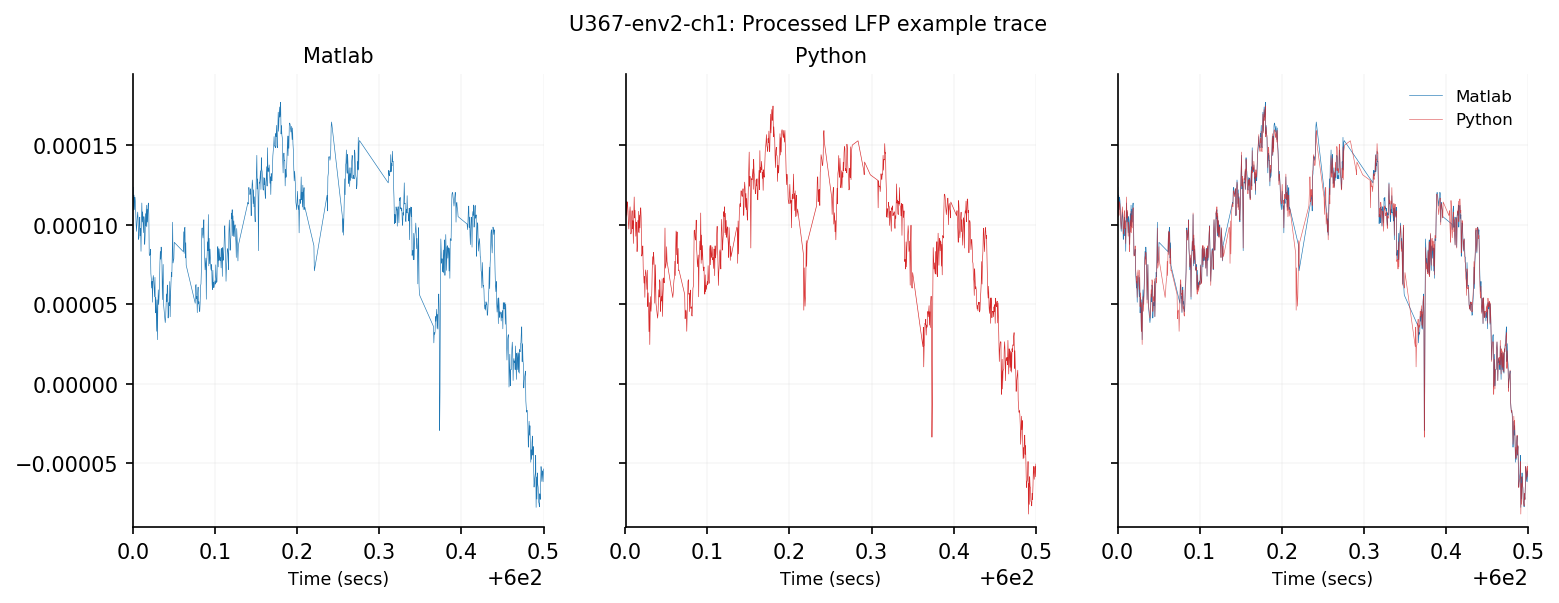

In [12]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4), sharey=True)
ax = np.ravel(ax)

plot_trace(np.expand_dims(mat['lfp'].squeeze(), 0), 
           start=600, duration=0.5, x_units='secs', colors=['C0'], linewidths=[0.3],
           fig=fig, ax=ax[0], title='Matlab')

plot_trace(np.expand_dims(lfp_proc.sel(channel='1'), 0), 
           start=600, duration=0.5, x_units='secs', colors=['C1'], linewidths=[0.3],
           fig=fig, ax=ax[1], title='Python')

plot_trace(np.vstack((mat['lfp'].squeeze(), lfp_proc.sel(channel='1'))), 
           start=600, duration=0.5, x_units='secs', colors=['C0', 'C1'], 
           alphas=[1, 0.75], linewidths=[0.3, 0.3],
           legend_labels=['Matlab', 'Python'], fig=fig, ax=ax[2])

fig.suptitle('U367-env2-ch1: Processed LFP example trace')
f = os.path.join(figure_dir, 'matlab_vs_python_LFPtrace_{}_ch{}.png'.format(subj_sess, '1'))
fig.savefig(f)

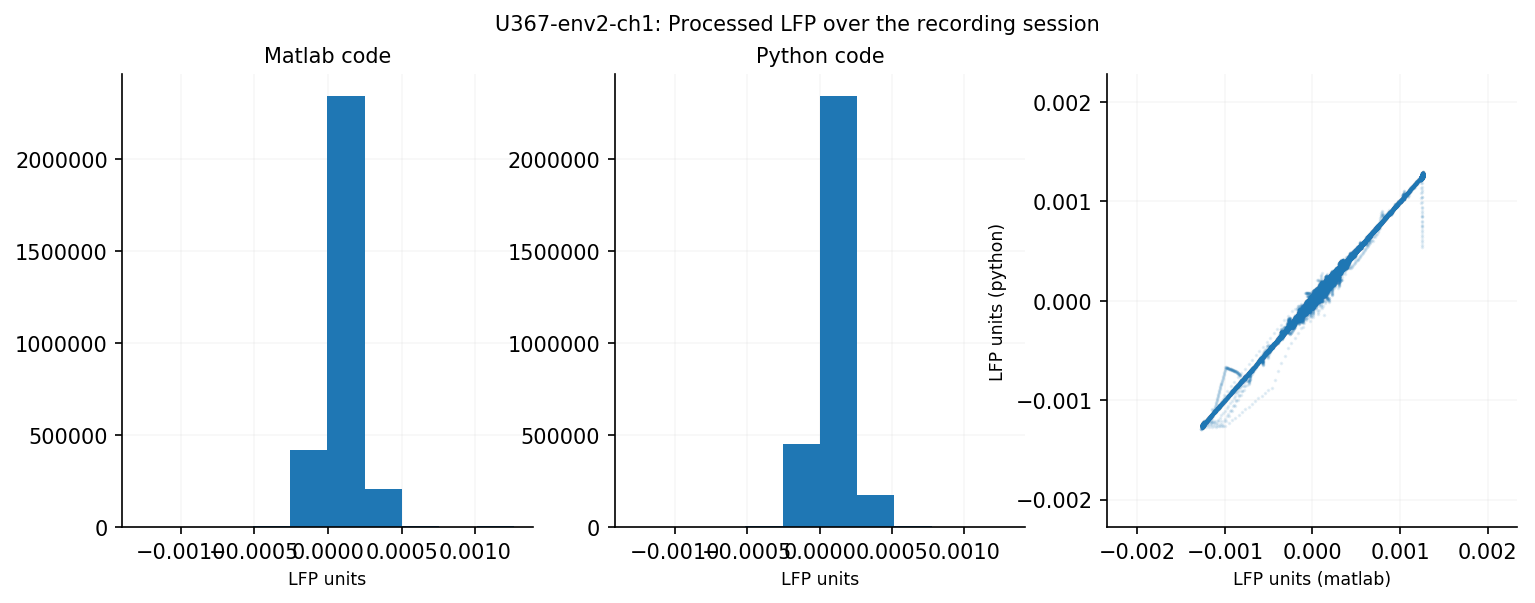

In [15]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax = np.ravel(ax)
chan = '1'

ax[0].hist(mat['lfp'].squeeze())
ax[0].set_title('Matlab code')
ax[0].set_xlabel('LFP units')

ax[1].hist(lfp_proc.sel(channel='1'))
ax[1].set_title('Python code')
ax[1].set_xlabel('LFP units')

ax[2].scatter(mat['lfp'].squeeze(), lfp_proc.sel(channel='1'), alpha=0.1, s=0.5)
ax[2].set_xlabel('LFP units (matlab)')
ax[2].set_ylabel('LFP units (python)')

fig.suptitle('U367-env2-ch1: Processed LFP over the recording session')
f = os.path.join(figure_dir, 'matlab_vs_python_LFP_{}_ch{}.png'.format(subj_sess, chan))
#fig.savefig(f)

In [331]:
print('** Comparing the output of dan_fl_getRateAndPow.m versus python code **\n')
print('Firing rate for U367-env2-ch1 (python smoothed fr; matlab unsmoothed fr):\n')
print('matlab (clus1) vs. python (clus1): ', stats.spearmanr(mat['spikeRate'][0, 3:-3], epoch_fr.sel(cluster=0)))
print('matlab (clus2) vs. python (clus2): ', stats.spearmanr(mat['spikeRate'][1, 3:-3], epoch_fr.sel(cluster=1)))
print('matlab (clus1) vs. python (clus2): ', stats.spearmanr(mat['spikeRate'][0, 3:-3], epoch_fr.sel(cluster=1)))
print('matlab (clus2) vs. python (clus1): ', stats.spearmanr(mat['spikeRate'][1, 3:-3], epoch_fr.sel(cluster=0)))
print('matlab vs. python (clus1), -1 epoch alignment: ', stats.spearmanr(mat['spikeRate'][0, 2:-4], epoch_fr.sel(cluster=0)))
print('matlab vs. python (clus1), +1 epoch alignment: ', stats.spearmanr(mat['spikeRate'][0, 4:-2], epoch_fr.sel(cluster=0)))
print('matlab vs. python (clus2), -1 epoch alignment: ', stats.spearmanr(mat['spikeRate'][1, 2:-4], epoch_fr.sel(cluster=1)))
print('matlab vs. python (clus2), +1 epoch alignment: ', stats.spearmanr(mat['spikeRate'][1, 4:-2], epoch_fr.sel(cluster=1)))
print('matlab vs. python (clus1), -3 epoch alignment: ', stats.spearmanr(mat['spikeRate'][0, 0:-6], epoch_fr.sel(cluster=0)))
print('matlab vs. python (clus2), -3 epoch alignment: ', stats.spearmanr(mat['spikeRate'][1, 0:-6], epoch_fr.sel(cluster=1)))

** Comparing the output of dan_fl_getRateAndPow.m versus python code **

Firing rate for U367-env2-ch1 (python smoothed fr; matlab unsmoothed fr):

matlab (clus1) vs. python (clus1):  SpearmanrResult(correlation=0.9060758928818325, pvalue=0.0)
matlab (clus2) vs. python (clus2):  SpearmanrResult(correlation=0.8974298848477256, pvalue=0.0)
matlab (clus1) vs. python (clus2):  SpearmanrResult(correlation=0.40511417718939524, pvalue=3.26497013542065e-118)
matlab (clus2) vs. python (clus1):  SpearmanrResult(correlation=0.39441531661183804, pvalue=1.3065790403001175e-111)
matlab vs. python (clus1), -1 epoch alignment:  SpearmanrResult(correlation=0.3296004789408797, pvalue=1.5933623525602568e-76)
matlab vs. python (clus1), +1 epoch alignment:  SpearmanrResult(correlation=0.3348778244656503, pvalue=4.4040511722517926e-79)
matlab vs. python (clus2), -1 epoch alignment:  SpearmanrResult(correlation=0.30835612386999967, pvalue=9.98333862958276e-67)
matlab vs. python (clus2), +1 epoch alignment:  

In [330]:
print('** Comparing the output of dan_fl_getRateAndPow.m versus python code **\n')
print('Smoothed firing rate for U367-env2-ch1 (python smoothed fr; matlab smoothed fr):\n')
print('matlab (clus1) vs. python (clus1): ', stats.spearmanr(mat['smSpikeRate'][0, 3:-3], epoch_fr.sel(cluster=0)))
print('matlab (clus2) vs. python (clus2): ', stats.spearmanr(mat['smSpikeRate'][1, 3:-3], epoch_fr.sel(cluster=1)))
print('matlab (clus1) vs. python (clus2): ', stats.spearmanr(mat['smSpikeRate'][0, 3:-3], epoch_fr.sel(cluster=1)))
print('matlab (clus2) vs. python (clus1): ', stats.spearmanr(mat['smSpikeRate'][1, 3:-3], epoch_fr.sel(cluster=0)))
print('matlab vs. python (clus1), -1 epoch alignment: ', stats.spearmanr(mat['smSpikeRate'][0, 2:-4], epoch_fr.sel(cluster=0)))
print('matlab vs. python (clus1), +1 epoch alignment: ', stats.spearmanr(mat['smSpikeRate'][0, 4:-2], epoch_fr.sel(cluster=0)))
print('matlab vs. python (clus2), -1 epoch alignment: ', stats.spearmanr(mat['smSpikeRate'][1, 2:-4], epoch_fr.sel(cluster=1)))
print('matlab vs. python (clus2), +1 epoch alignment: ', stats.spearmanr(mat['smSpikeRate'][1, 4:-2], epoch_fr.sel(cluster=1)))
print('matlab vs. python (clus1), -3 epoch alignment: ', stats.spearmanr(mat['smSpikeRate'][0, 0:-6], epoch_fr.sel(cluster=0)))
print('matlab vs. python (clus2), -3 epoch alignment: ', stats.spearmanr(mat['smSpikeRate'][1, 0:-6], epoch_fr.sel(cluster=1)))

** Comparing the output of dan_fl_getRateAndPow.m versus python code **

Smoothed firing rate for U367-env2-ch1 (python smoothed fr; matlab smoothed fr):

matlab (clus1) vs. python (clus1):  SpearmanrResult(correlation=0.999888828285272, pvalue=0.0)
matlab (clus2) vs. python (clus2):  SpearmanrResult(correlation=0.9998829945099779, pvalue=0.0)
matlab (clus1) vs. python (clus2):  SpearmanrResult(correlation=0.43482781113379887, pvalue=7.266427599093193e-138)
matlab (clus2) vs. python (clus1):  SpearmanrResult(correlation=0.4340989228634352, pvalue=2.33033291058873e-137)
matlab vs. python (clus1), -1 epoch alignment:  SpearmanrResult(correlation=0.4666488318799392, pvalue=3.2928636226680887e-161)
matlab vs. python (clus1), +1 epoch alignment:  SpearmanrResult(correlation=0.46571491406817694, pvalue=1.7322144983959255e-160)
matlab vs. python (clus2), -1 epoch alignment:  SpearmanrResult(correlation=0.45411217908939877, pvalue=1.02757575630294e-151)
matlab vs. python (clus2), +1 epoch alig

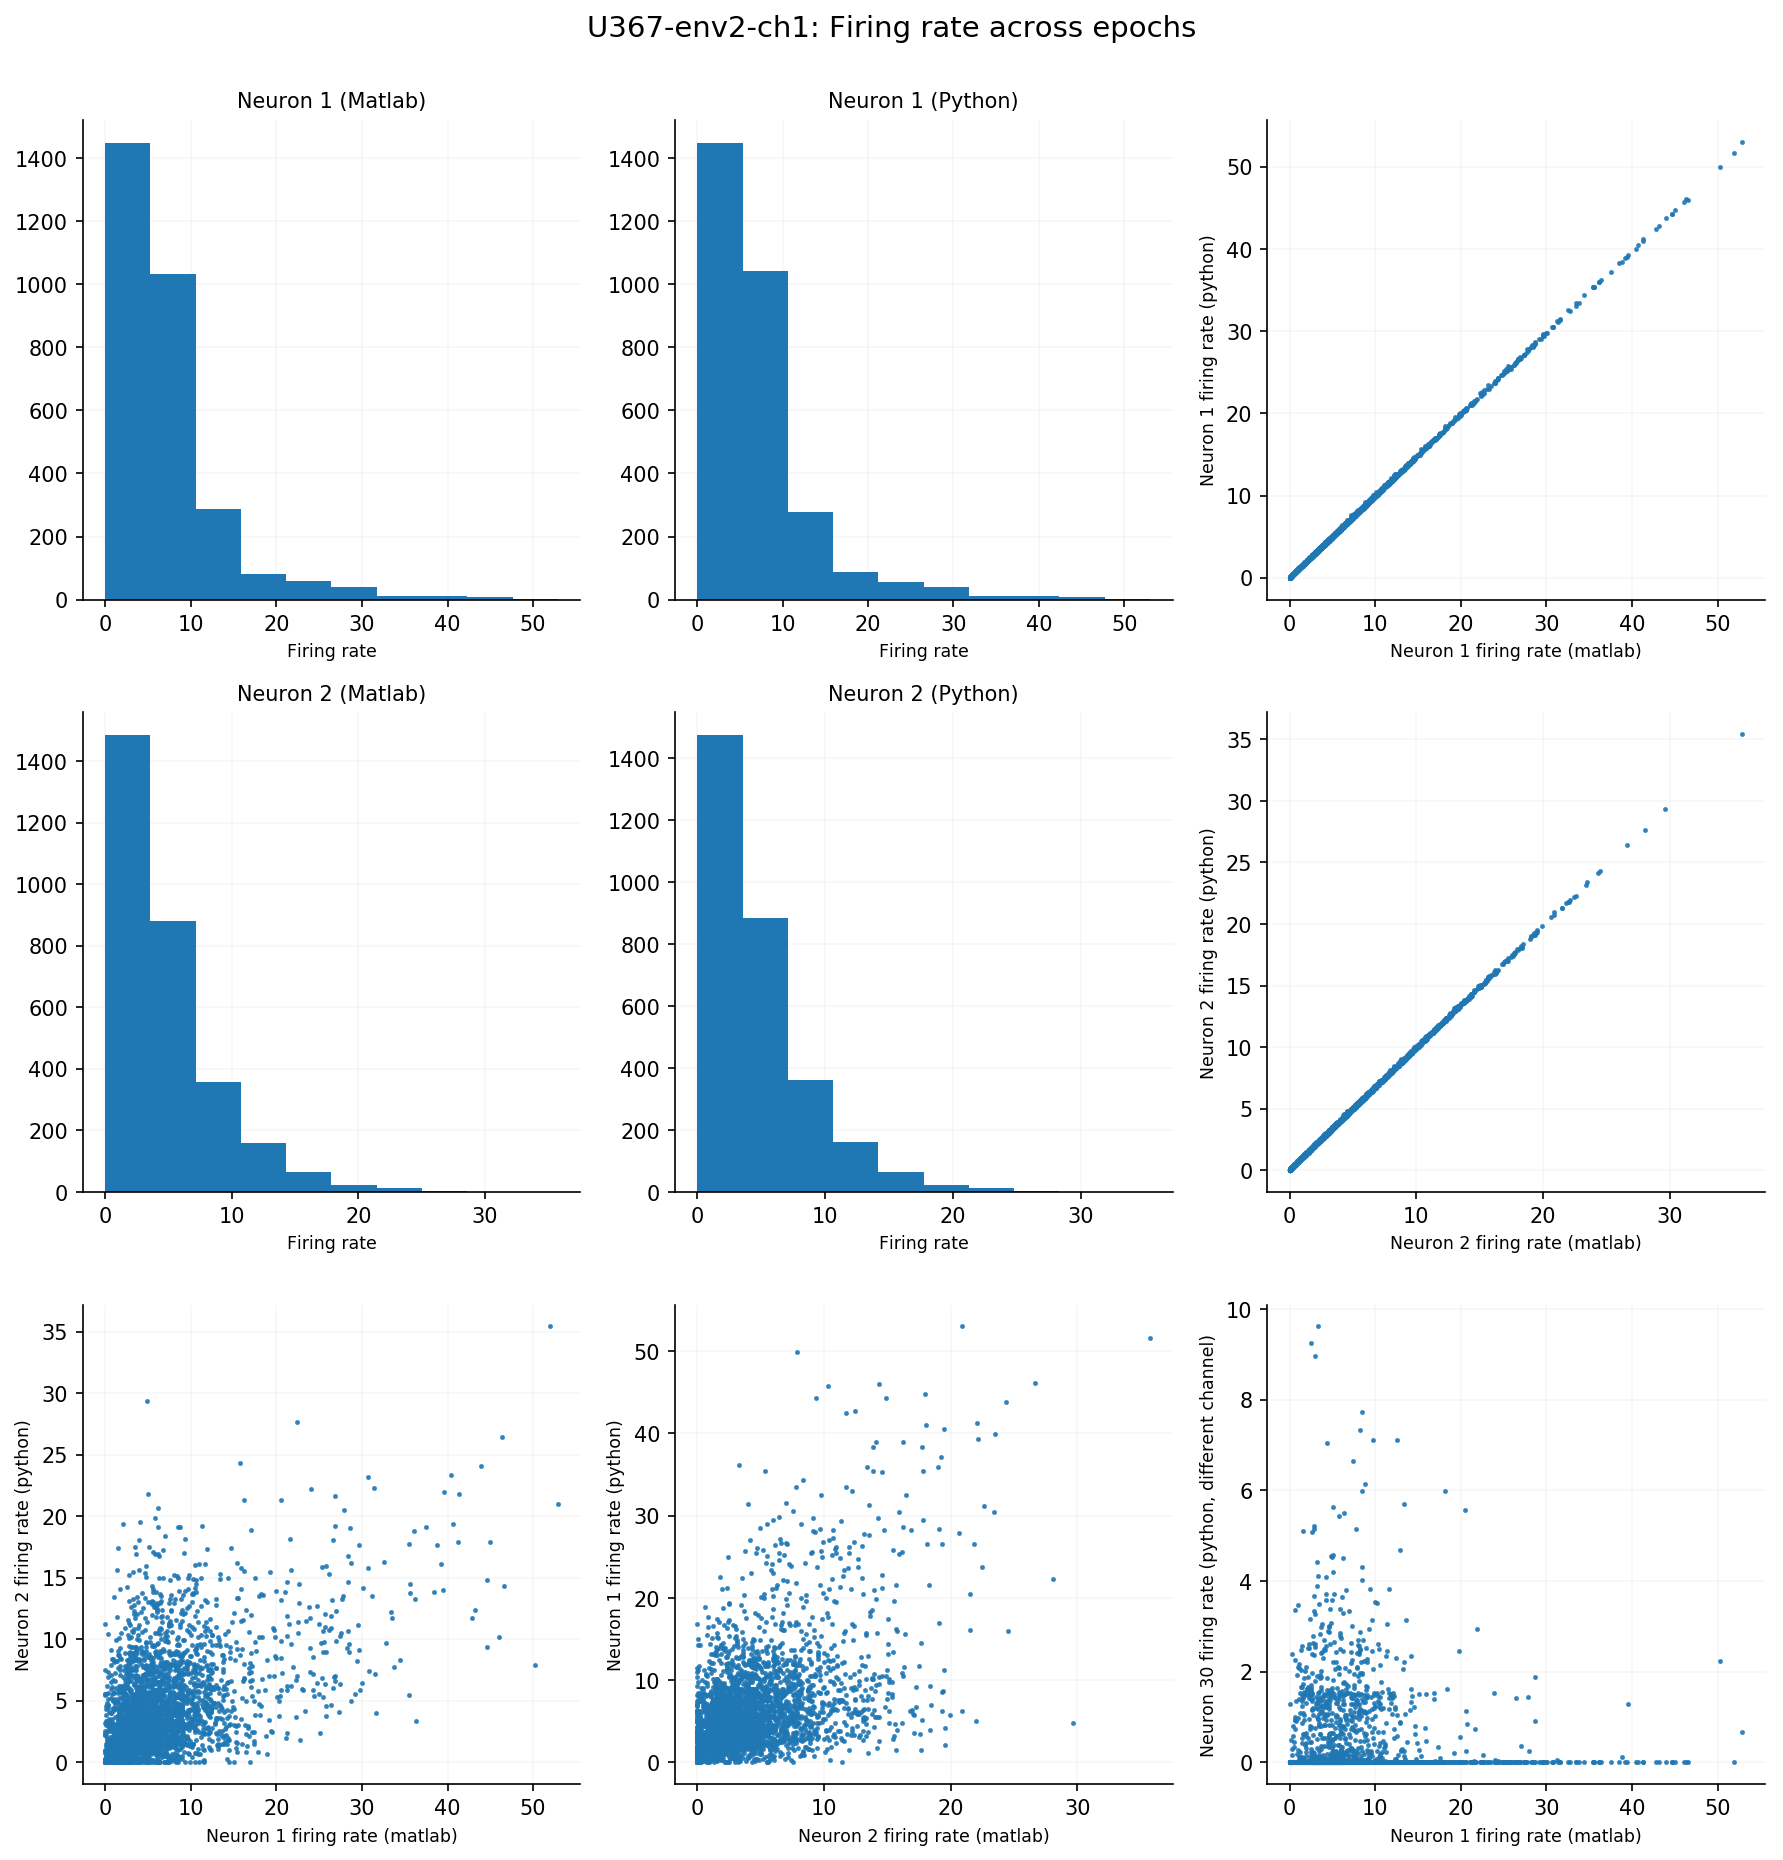

In [376]:
fig, ax = plt.subplots(3, 3, figsize=(12, 12))
ax = np.ravel(ax)

ax[0].hist(mat['smSpikeRate'][0, 3:-3])
ax[0].set_title('Neuron 1 (Matlab)')
ax[0].set_xlabel('Firing rate')

ax[1].hist(epoch_fr.sel(cluster=0))
ax[1].set_title('Neuron 1 (Python)')
ax[1].set_xlabel('Firing rate')

ax[2].scatter(mat['smSpikeRate'][0, 3:-3], epoch_fr.sel(cluster=0), alpha=0.8, s=2)
ax[2].set_xlabel('Neuron 1 firing rate (matlab)')
ax[2].set_ylabel('Neuron 1 firing rate (python)')

###################

ax[3].hist(mat['smSpikeRate'][1, 3:-3])
ax[3].set_title('Neuron 2 (Matlab)')
ax[3].set_xlabel('Firing rate')

ax[4].hist(epoch_fr.sel(cluster=1))
ax[4].set_title('Neuron 2 (Python)')
ax[4].set_xlabel('Firing rate')

ax[5].scatter(mat['smSpikeRate'][1, 3:-3], epoch_fr.sel(cluster=1), alpha=0.8, s=2)
ax[5].set_xlabel('Neuron 2 firing rate (matlab)')
ax[5].set_ylabel('Neuron 2 firing rate (python)')

###################

ax[6].scatter(mat['smSpikeRate'][0, 3:-3], epoch_fr.sel(cluster=1), alpha=0.8, s=2)
ax[6].set_xlabel('Neuron 1 firing rate (matlab)')
ax[6].set_ylabel('Neuron 2 firing rate (python)')

ax[7].scatter(mat['smSpikeRate'][1, 3:-3], epoch_fr.sel(cluster=0), alpha=0.8, s=2)
ax[7].set_xlabel('Neuron 2 firing rate (matlab)')
ax[7].set_ylabel('Neuron 1 firing rate (python)')

ax[8].scatter(mat['smSpikeRate'][0, 3:-3], epoch_fr.sel(cluster=29), alpha=0.8, s=2)
ax[8].set_xlabel('Neuron 1 firing rate (matlab)')
ax[8].set_ylabel('Neuron 30 firing rate (python, different channel)')

fig.tight_layout(pad=1.12)
fig.suptitle('U367-env2-ch1: Firing rate across epochs', y=1.03, size=14)
f = os.path.join(figure_dir, 'matlab_vs_python_epoch_fr_{}_ch{}.png'.format(subj_sess, chan))
fig.savefig(f)

In [579]:
print('** Comparing the output of dan_fl_getRateAndPow.m versus python code **\n')
print('Smoothed firing rate vs. mean power across epochs at 50 freqs for U367-env2-ch1:\n')

print('Power over freq (matlab vs. python): ', stats.spearmanr(epoch_power_.sel(channel='1').mean('epoch'), np.mean(mat['pow'][:, 3:-3], axis=1)))
print('Power over epoch (matlab vs. python): ', stats.spearmanr(epoch_power_.sel(channel='1').mean('freq'), np.mean(mat['pow'][:, 3:-3], axis=0)))
print('Power over freq and epoch (matlab vs. python): ', stats.spearmanr(epoch_power_.sel(channel='1').T.data.flatten(), 
                                                                         mat['pow'][:, 3:-3].flatten()))

print('Neuron 1 FR vs. power (matlab): ', stats.spearmanr(mat['smSpikeRate'][0, 3:-3], np.mean(mat['pow'][:, 3:-3], axis=0)))
print('Neuron 2 FR vs. power (matlab): ', stats.spearmanr(mat['smSpikeRate'][1, 3:-3], np.mean(mat['pow'][:, 3:-3], axis=0)))

print('Neuron 1 FR vs. power (python): ', stats.spearmanr(epoch_power_.sel(channel='1').mean('freq'), epoch_fr.sel(cluster=0)))
print('Neuron 2 FR vs. power (python): ', stats.spearmanr(epoch_power_.sel(channel='1').mean('freq'), epoch_fr.sel(cluster=1)))

print('Neuron 1 FR (python) vs. power (matlab): ', stats.spearmanr(epoch_fr.sel(cluster=0), np.mean(mat['pow'][:, 3:-3], axis=0)))
print('Neuron 1 FR (matlab) vs. power (python): ', stats.spearmanr(mat['smSpikeRate'][0, 3:-3], epoch_power_.sel(channel='1').mean('freq')))

** Comparing the output of dan_fl_getRateAndPow.m versus python code **

Smoothed firing rate vs. mean power across epochs at 50 freqs for U367-env2-ch1:

Power over freq (matlab vs. python):  SpearmanrResult(correlation=0.4582472989195678, pvalue=0.0008183358370313335)
Power over epoch (matlab vs. python):  SpearmanrResult(correlation=0.7676950754993762, pvalue=0.0)
Power over freq and epoch (matlab vs. python):  SpearmanrResult(correlation=0.6991908288020809, pvalue=0.0)
Neuron 1 FR vs. power (matlab):  SpearmanrResult(correlation=0.19474205235759487, pvalue=6.997016332780223e-27)
Neuron 2 FR vs. power (matlab):  SpearmanrResult(correlation=0.08817002973132493, pvalue=1.414535056788618e-06)
Neuron 1 FR vs. power (python):  SpearmanrResult(correlation=-0.010834842439316332, pvalue=0.554162497468409)
Neuron 2 FR vs. power (python):  SpearmanrResult(correlation=-0.042496781615083204, pvalue=0.020280585067846524)
Neuron 1 FR (python) vs. power (matlab):  SpearmanrResult(correlation=0.194

In [462]:
print('** Comparing the output of dan_fl_getRateAndPow.m versus python code **\n')
print('Smoothed firing rate vs. mean power across epochs at 50 freqs for U367-env2-ch1:\n')

print('Power over freq (matlab vs. python): ', stats.spearmanr(epoch_power.sel(channel='1').mean('epoch'), np.mean(mat['pow'][:, 3:-3], axis=1)))
print('Power over epoch (matlab vs. python): ', stats.spearmanr(epoch_power.sel(channel='1').mean('freq'), np.mean(mat['pow'][:, 3:-3], axis=0)))
print('Power over freq and epoch (matlab vs. python): ', stats.spearmanr(epoch_power.sel(channel='1').T.data.flatten(), 
                                                                         mat['pow'][:, 3:-3].flatten()))

print('Neuron 1 FR vs. power (matlab): ', stats.spearmanr(mat['smSpikeRate'][0, 3:-3], np.mean(mat['pow'][:, 3:-3], axis=0)))
print('Neuron 2 FR vs. power (matlab): ', stats.spearmanr(mat['smSpikeRate'][1, 3:-3], np.mean(mat['pow'][:, 3:-3], axis=0)))

print('Neuron 1 FR vs. power (python): ', stats.spearmanr(epoch_power.sel(channel='1').mean('freq'), epoch_fr.sel(cluster=0)))
print('Neuron 2 FR vs. power (python): ', stats.spearmanr(epoch_power.sel(channel='1').mean('freq'), epoch_fr.sel(cluster=1)))

print('Neuron 1 FR (python) vs. power (matlab): ', stats.spearmanr(epoch_fr.sel(cluster=0), np.mean(mat['pow'][:, 3:-3], axis=0)))
print('Neuron 1 FR (matlab) vs. power (python): ', stats.spearmanr(mat['smSpikeRate'][0, 3:-3], epoch_power.sel(channel='1').mean('freq')))

** Comparing the output of dan_fl_getRateAndPow.m versus python code **

Smoothed firing rate vs. mean power across epochs at 50 freqs for U367-env2-ch1:

Power over freq (matlab vs. python):  SpearmanrResult(correlation=0.6155582232893156, pvalue=1.9597601206884697e-06)
Power over epoch (matlab vs. python):  SpearmanrResult(correlation=0.767000036816116, pvalue=0.0)
Power over freq and epoch (matlab vs. python):  SpearmanrResult(correlation=0.029403610214777314, pvalue=6.766236767958844e-30)
Neuron 1 FR vs. power (matlab):  SpearmanrResult(correlation=0.19474205235759487, pvalue=6.997016332780223e-27)
Neuron 2 FR vs. power (matlab):  SpearmanrResult(correlation=0.08817002973132493, pvalue=1.414535056788618e-06)
Neuron 1 FR vs. power (python):  SpearmanrResult(correlation=-0.012859429341079429, pvalue=0.4826316764807017)
Neuron 2 FR vs. power (python):  SpearmanrResult(correlation=-0.04483688609617641, pvalue=0.014323173016282161)
Neuron 1 FR (python) vs. power (matlab):  SpearmanrResu

In [527]:
print(np.mean(epoch_power.sel(channel='1').data), np.std(epoch_power.sel(channel='1').data))
print(np.mean(epoch_power.sel(channel='1').data, axis=0), np.std(epoch_power.sel(channel='1').data, axis=0)) # mean over epoch
#print(np.mean(epoch_power.sel(channel='1').data, axis=1), np.std(epoch_power.sel(channel='1').data, axis=1)) # mean over freq

print(np.mean(mat['pow'][:, 3:-3]), np.std(mat['pow'][:, 3:-3]))
print(np.mean(mat['pow'][:, 3:-3], axis=1), np.std(mat['pow'][:, 3:-3], axis=1)) # mean over epoch
#print(np.mean(mat['pow'][:, 3:-3], axis=0), np.std(mat['pow'][:, 3:-3], axis=0)) # mean over freq

1.4156279396815157e-05 0.9228681947055413
[ 1.46315578  1.39248371  1.32042652  1.25345823  1.18627175  1.12131351
  1.06096219  1.00676432  0.9584327   0.92823557  0.9254373   0.94501693
  0.95836923  0.94605548  0.89829297  0.81419362  0.70553083  0.58472811
  0.46610166  0.3614201   0.27070805  0.19218506  0.11736378  0.03908909
 -0.04015066 -0.12010494 -0.19914143 -0.27502823 -0.34754184 -0.41554375
 -0.47860151 -0.53702121 -0.59298669 -0.64838559 -0.6954341  -0.71612994
 -0.70309248 -0.68683148 -0.70295985 -0.76150758 -0.85177146 -0.95264155
 -1.04816434 -1.12949595 -1.19698943 -1.25538054 -1.30971485 -1.3635528
 -1.41709518 -1.47002129] [0.39721749 0.38455049 0.38020868 0.37134599 0.36645255 0.35707114
 0.34430415 0.33626755 0.32698597 0.31399348 0.30186173 0.30368477
 0.31861379 0.33339244 0.33585997 0.32446932 0.29988183 0.26915358
 0.24204207 0.22309162 0.21401849 0.20718095 0.20074496 0.19210609
 0.18183468 0.17362212 0.16702175 0.1612788  0.15656762 0.15241318
 0.14862455 0.

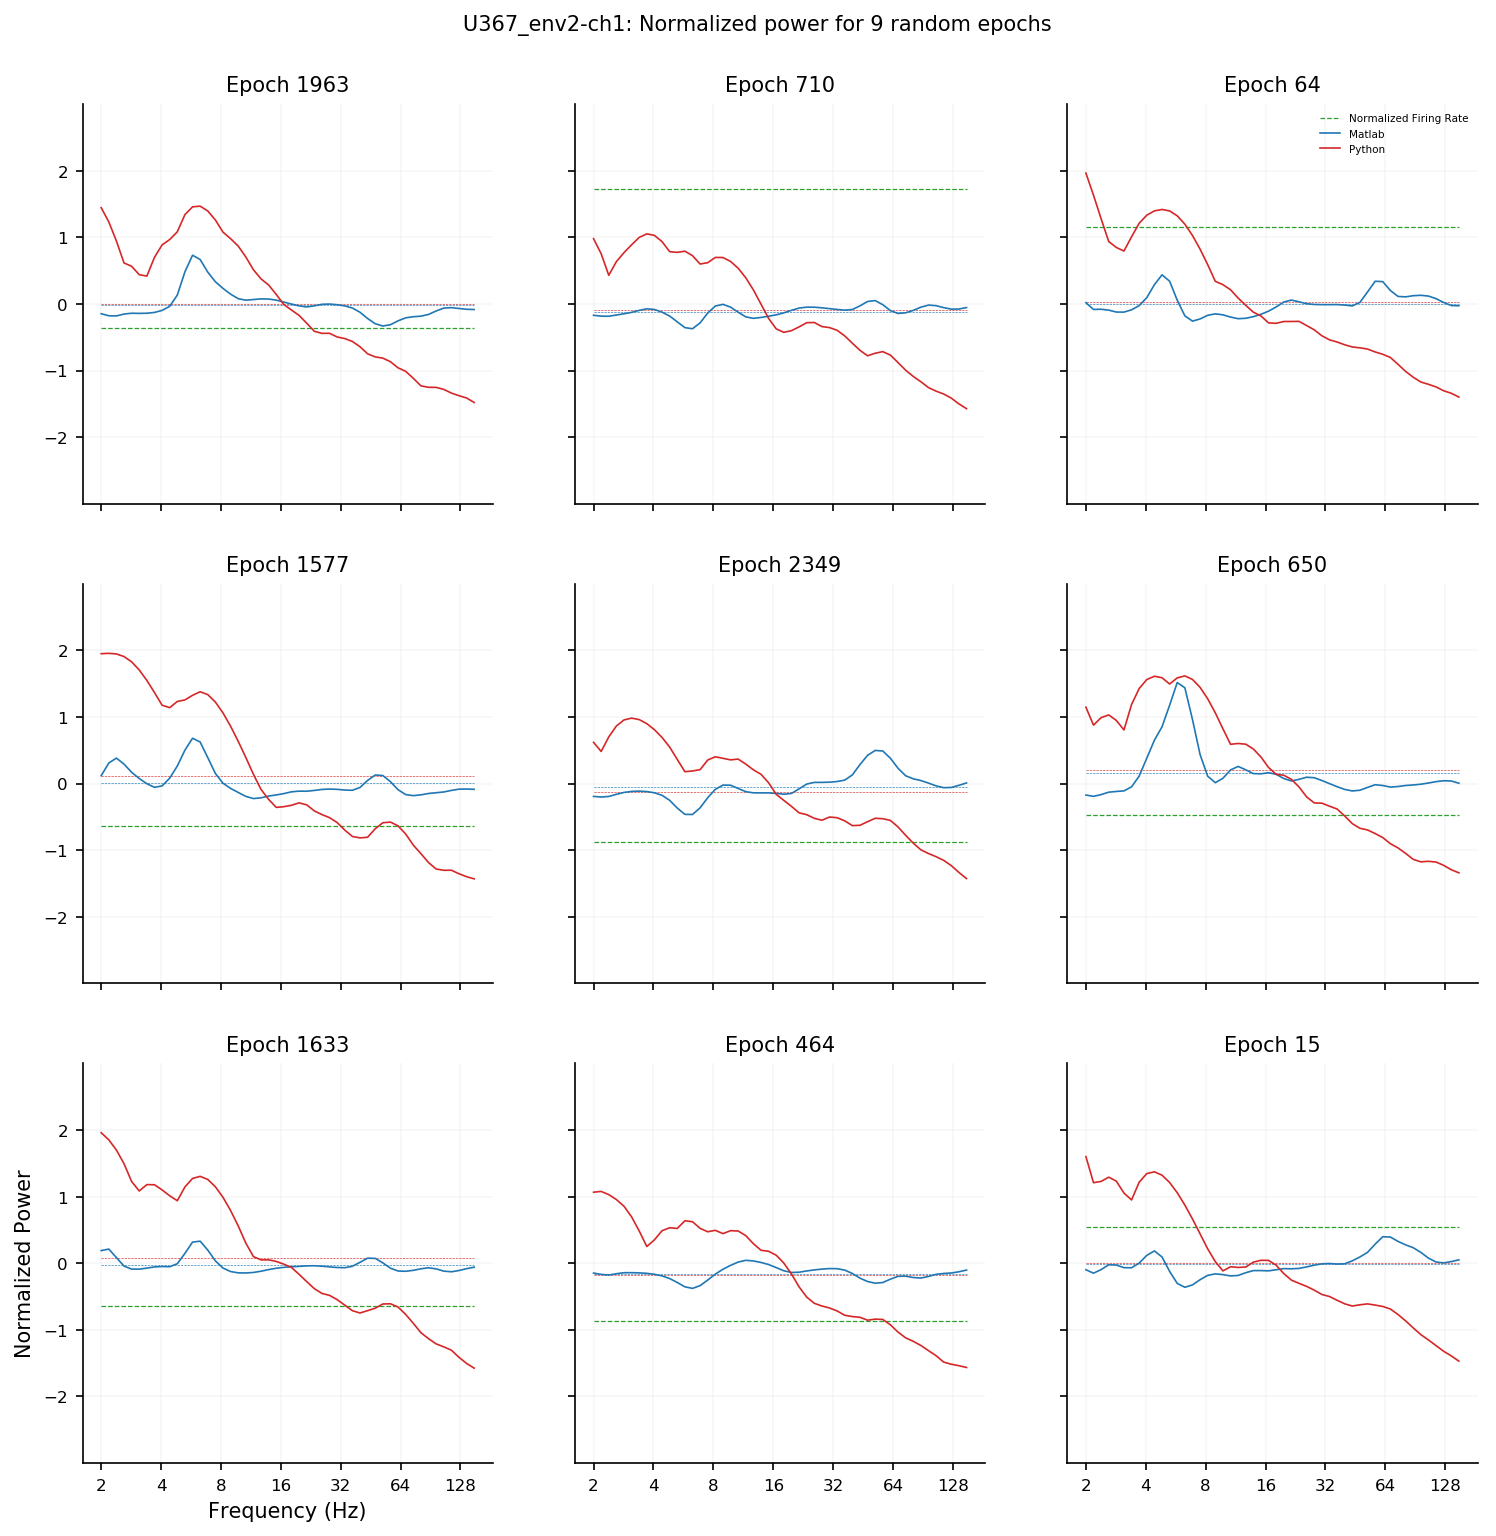

In [530]:
n_epochs = len(epoch_power.epoch)
epochs = [int(i) for i in np.random.rand(9) * n_epochs]

fig, ax = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(12, 12))
ax = np.ravel(ax)
for i, epoch in enumerate(epochs):
    frZ = (epoch_fr.sel(cluster=0, epoch=epoch).data - epoch_fr.sel(cluster=0).mean('epoch')).data / epoch_fr.sel(cluster=0).std('epoch').data
    ax[i].plot(np.log10(freqs), np.ones(len(freqs))*frZ, linewidth=0.6, linestyle='--', color='C2', label='Normalized Firing Rate')
    ax[i].plot(np.log10(freqs), np.ones(len(freqs))*np.mean(mat['pow'][:, 3+epoch]), color='C0', linewidth=0.3, linestyle='--')
    ax[i].plot(np.log10(freqs), np.ones(len(freqs))*np.mean(epoch_power.sel(channel='1', epoch=epoch)).data, color='C1', linewidth=0.3, linestyle='--')
    ax[i].plot(np.log10(freqs), mat['pow'][:, 3+epoch], color='C0', label='Matlab')
    ax[i].plot(np.log10(freqs), epoch_power.sel(channel='1', epoch=epoch), color='C1', label='Python')
    
    ax[i].set_xticks(np.log10([2, 4, 8, 16, 32, 64, 128]))
    ax[i].set_xticklabels([2, 4, 8, 16, 32, 64, 128])
    ax[i].set_yticks([-2, -1, 0, 1, 2])
    ax[i].set_ylim([-3, 3])
    for item in ax[i].get_xticklabels() + ax[i].get_yticklabels():
        item.set_fontsize(8)
    for item in (ax[i].xaxis.label, ax[i].yaxis.label):
        item.set_fontsize(10)
    if i == 2:
        ax[i].legend(loc=1, prop={'size': 5}, edgecolor='w')
    if i == 6:
        ax[i].set_xlabel('Frequency (Hz)')
        ax[i].set_ylabel('Normalized Power')
    ax[i].set_title('Epoch {}'.format(epoch))
    
fig.suptitle('{}-ch1: Normalized power for 9 random epochs'.format(subj_sess), 
             y=0.93, fontsize=10)
f = os.path.join(figure_dir, 'matlab_vs_python_fr_vs_power_some_random_epochs_{}_ch{}.png'.format(subj_sess, chan))
fig.savefig(f)

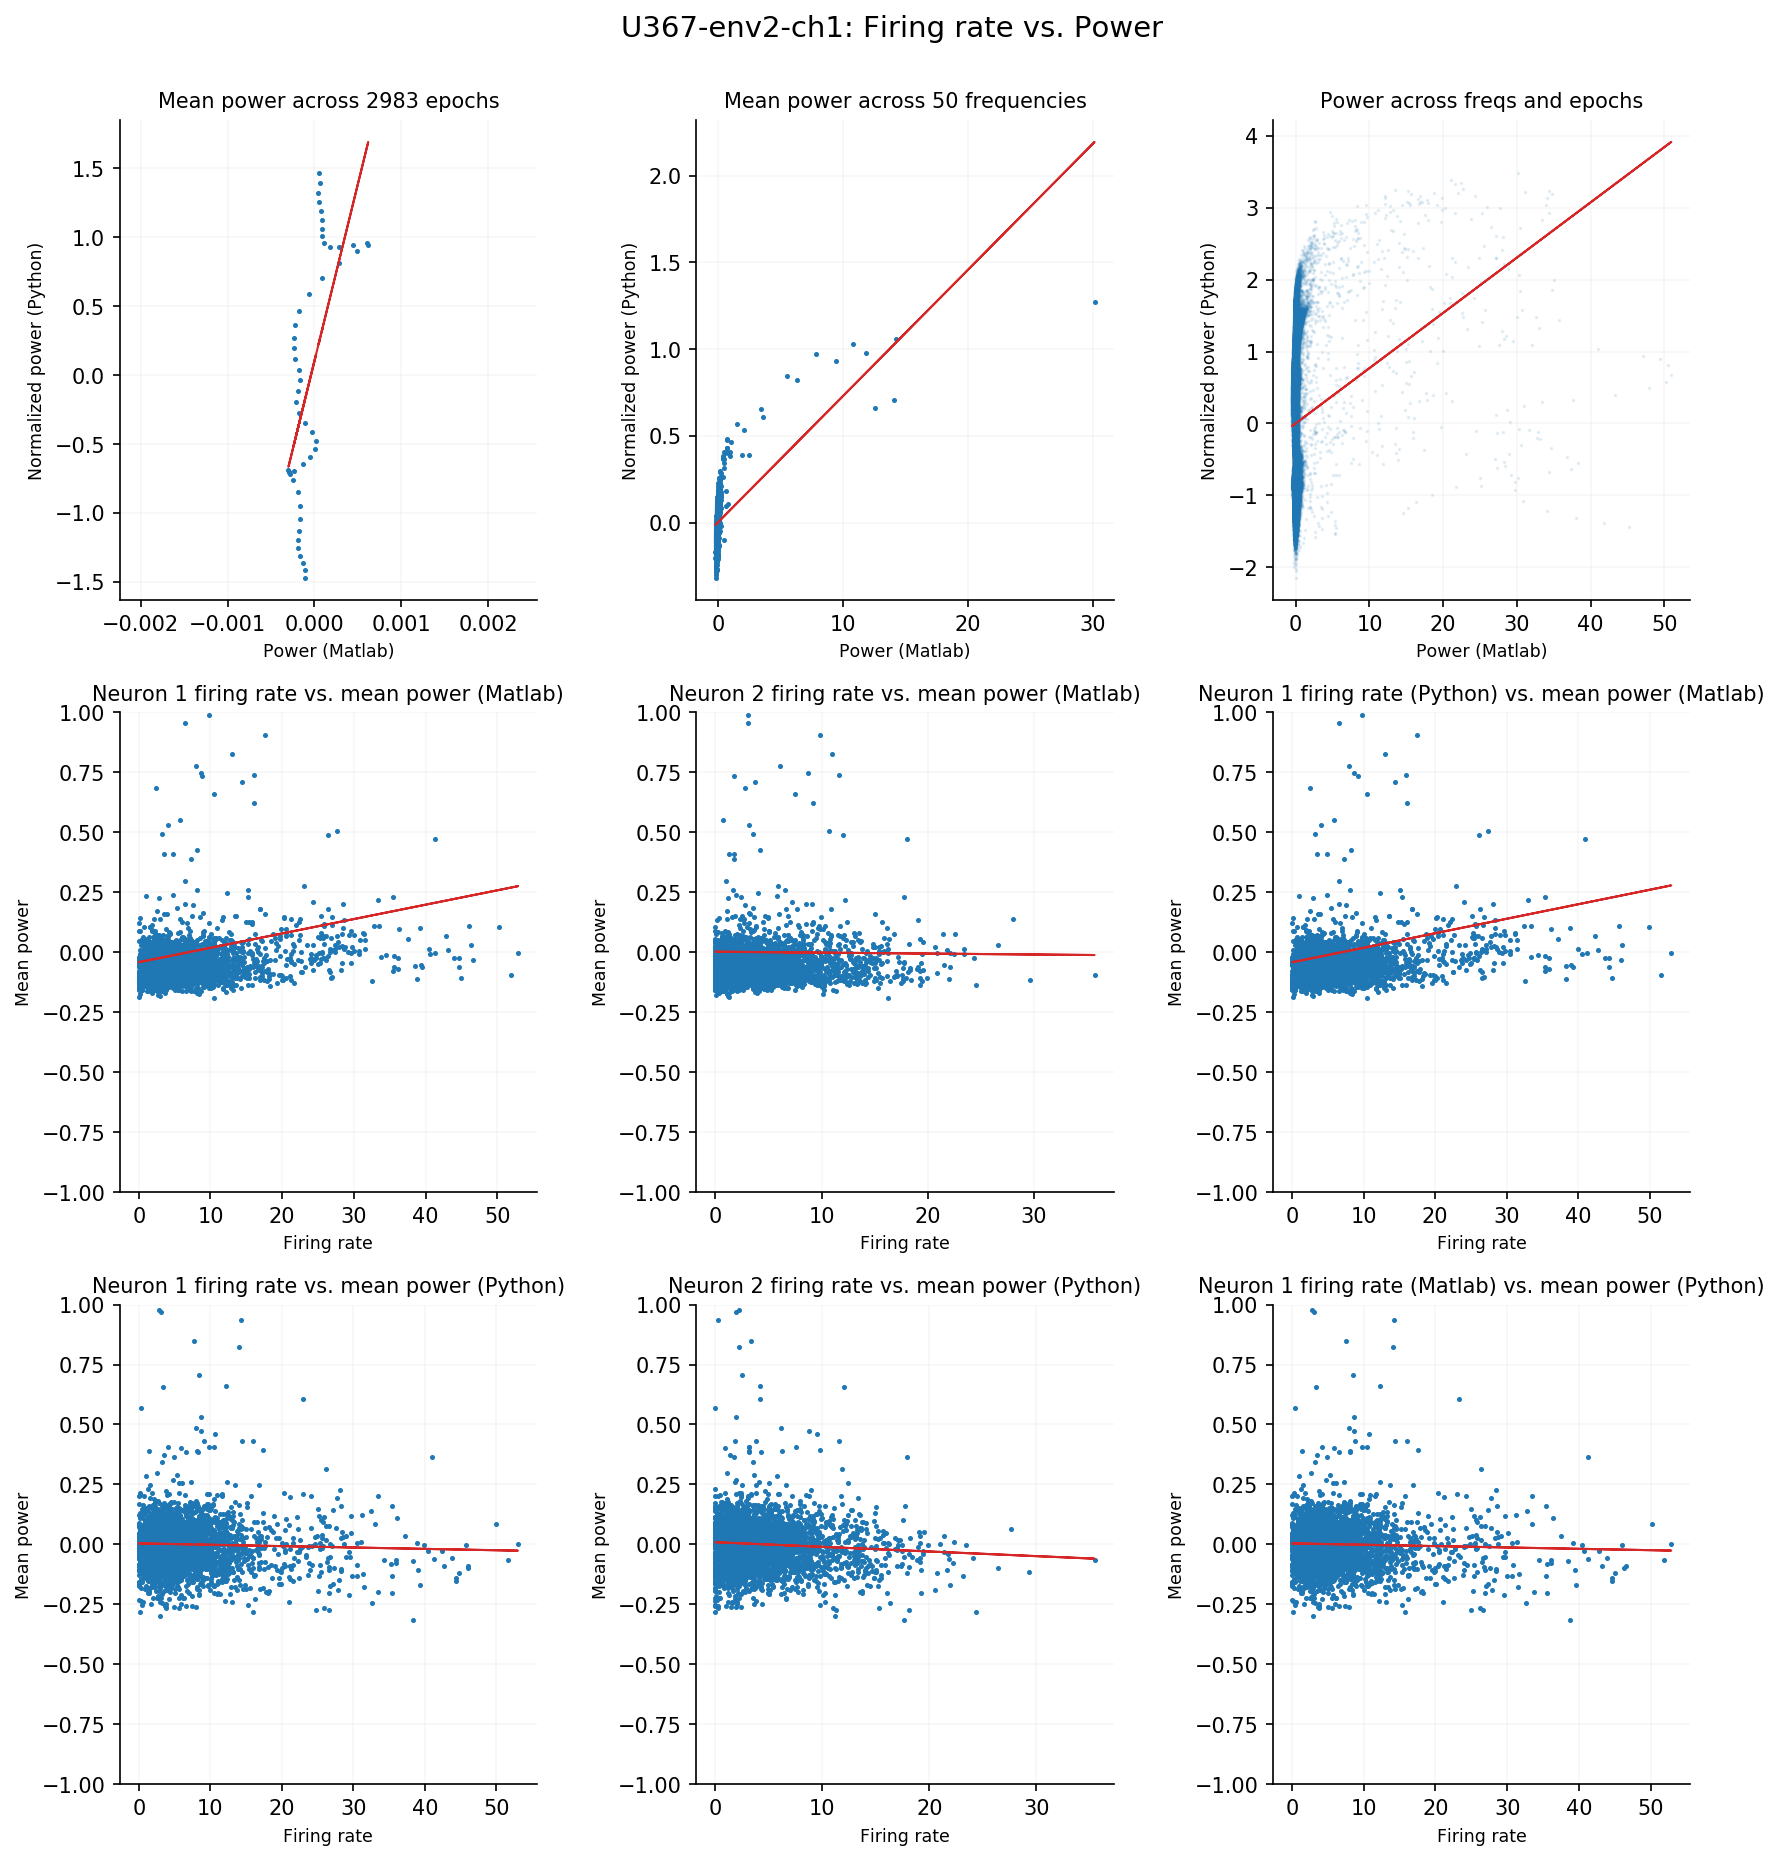

In [529]:
fig, ax = plt.subplots(3, 3, figsize=(12, 12))
ax = np.ravel(ax)

mat_power = mat['pow'][:, 3:-3]

ax[0].scatter(np.mean(mat_power, axis=1), epoch_power.sel(channel='1').mean('epoch'), s=2)
xi = np.mean(mat_power, axis=1)
y = epoch_power.sel(channel='1').mean('epoch')
slope, intercept, r_value, p_value, std_err = stats.linregress(xi, y)
ax[0].plot(xi, slope * xi + intercept, color='C1', linewidth=1)
ax[0].set_xlabel('Power (Matlab)')
ax[0].set_ylabel('Normalized power (Python)')
ax[0].set_title('Mean power across 2983 epochs')

ax[1].scatter(np.mean(mat_power, axis=0), epoch_power.sel(channel='1').mean('freq'), s=2)
xi = np.mean(mat_power, axis=0)
y = epoch_power.sel(channel='1').mean('freq')
slope, intercept, r_value, p_value, std_err = stats.linregress(xi, y)
ax[1].plot(xi, slope * xi + intercept, color='C1', linewidth=1)
ax[1].set_xlabel('Power (Matlab)')
ax[1].set_ylabel('Normalized power (Python)')
ax[1].set_title('Mean power across 50 frequencies')

ax[2].scatter(mat_power.flatten(), epoch_power.sel(channel='1').T.data.flatten(), alpha=0.1, s=0.5)
xi = mat_power.flatten()
y = epoch_power.sel(channel='1').T.data.flatten()
slope, intercept, r_value, p_value, std_err = stats.linregress(xi, y)
ax[2].plot(xi, slope * xi + intercept, color='C1', linewidth=1)
ax[2].set_xlabel('Power (Matlab)')
ax[2].set_ylabel('Normalized power (Python)')
ax[2].set_title('Power across freqs and epochs')

###################

ax[3].scatter(mat['smSpikeRate'][0, 3:-3], np.mean(mat_power, axis=0), s=2)
xi = mat['smSpikeRate'][0, 3:-3]
y = np.mean(mat_power, axis=0)
slope, intercept, r_value, p_value, std_err = stats.linregress(xi, y)
ax[3].plot(xi, slope * xi + intercept, color='C1', linewidth=1)
ax[3].set_xlabel('Firing rate')
ax[3].set_ylim((-1, 1))
ax[3].set_ylabel('Mean power')
ax[3].set_title('Neuron 1 firing rate vs. mean power (Matlab)')

ax[4].scatter(mat['smSpikeRate'][1, 3:-3], np.mean(mat_power, axis=0), s=2)
xi = mat['smSpikeRate'][1, 3:-3]
y = np.mean(mat_power, axis=0)
slope, intercept, r_value, p_value, std_err = stats.linregress(xi, y)
ax[4].plot(xi, slope * xi + intercept, color='C1', linewidth=1)
ax[4].set_xlabel('Firing rate')
ax[4].set_ylim((-1, 1))
ax[4].set_ylabel('Mean power')
ax[4].set_title('Neuron 2 firing rate vs. mean power (Matlab)')

ax[5].scatter(epoch_fr.sel(cluster=0), np.mean(mat_power, axis=0), s=2)
xi = epoch_fr.sel(cluster=0)
y = np.mean(mat_power, axis=0)
slope, intercept, r_value, p_value, std_err = stats.linregress(xi, y)
ax[5].plot(xi, slope * xi + intercept, color='C1', linewidth=1)
ax[5].set_xlabel('Firing rate')
ax[5].set_ylim((-1, 1))
ax[5].set_ylabel('Mean power')
ax[5].set_title('Neuron 1 firing rate (Python) vs. mean power (Matlab)')

###################

ax[6].scatter(epoch_fr.sel(cluster=0), epoch_power.sel(channel='1').mean('freq'), s=2)
xi = epoch_fr.sel(cluster=0)
y = epoch_power.sel(channel='1').mean('freq')
slope, intercept, r_value, p_value, std_err = stats.linregress(xi, y)
ax[6].plot(xi, slope * xi + intercept, color='C1', linewidth=1)
ax[6].set_xlabel('Firing rate')
ax[6].set_ylim((-1, 1))
ax[6].set_ylabel('Mean power')
ax[6].set_title('Neuron 1 firing rate vs. mean power (Python)')

ax[7].scatter(epoch_fr.sel(cluster=1), epoch_power.sel(channel='1').mean('freq'), s=2)
xi = epoch_fr.sel(cluster=1)
y = epoch_power.sel(channel='1').mean('freq')
slope, intercept, r_value, p_value, std_err = stats.linregress(xi, y)
ax[7].plot(xi, slope * xi + intercept, color='C1', linewidth=1)
ax[7].set_xlabel('Firing rate')
ax[7].set_ylim((-1, 1))
ax[7].set_ylabel('Mean power')
ax[7].set_title('Neuron 2 firing rate vs. mean power (Python)')

ax[8].scatter(mat['smSpikeRate'][0, 3:-3], epoch_power.sel(channel='1').mean('freq'), s=2)
xi = mat['smSpikeRate'][0, 3:-3]
y = epoch_power.sel(channel='1').mean('freq')
slope, intercept, r_value, p_value, std_err = stats.linregress(xi, y)
ax[8].plot(xi, slope * xi + intercept, color='C1', linewidth=1)
ax[8].set_xlabel('Firing rate')
ax[8].set_ylim((-1, 1))
ax[8].set_ylabel('Mean power')
ax[8].set_title('Neuron 1 firing rate (Matlab) vs. mean power (Python)')

fig.tight_layout(pad=1.12)
fig.suptitle('U367-env2-ch1: Firing rate vs. Power', y=1.03, size=14)
f = os.path.join(figure_dir, 'matlab_vs_python_epoch_fr_vs_power_{}_ch{}.png'.format(subj_sess, chan))
fig.savefig(f)

In [386]:
np.mean(mat['pow'][:, 3:-3], axis=1)

array([ 5.53363430e-05,  6.39751986e-05,  4.64806410e-05,  5.27626689e-05,
        7.97460665e-05,  9.21837515e-05,  8.63875852e-05,  8.49316883e-05,
        1.10252318e-04,  1.73198806e-04,  2.81006157e-04,  4.47110748e-04,
        6.01263902e-04,  6.18774957e-04,  4.84109360e-04,  2.78077011e-04,
        9.06854915e-05, -5.93588754e-05, -1.72977224e-04, -2.24922911e-04,
       -2.34798675e-04, -2.39754963e-04, -2.23268245e-04, -1.83000307e-04,
       -1.67367434e-04, -1.88775574e-04, -2.06846415e-04, -1.82722095e-04,
       -1.10145109e-04, -3.09851481e-05,  1.70023201e-05,  9.42863224e-06,
       -4.69871872e-05, -1.35844575e-04, -2.31962790e-04, -2.87053385e-04,
       -2.95251303e-04, -2.99177150e-04, -2.94994829e-04, -2.50030480e-04,
       -1.92072792e-04, -1.71098643e-04, -1.67452206e-04, -1.72192327e-04,
       -1.85949310e-04, -1.88123320e-04, -1.61536602e-04, -1.28736696e-04,
       -1.09961379e-04, -1.10754739e-04])

In [966]:
## Create a TimeSeries of firing rate and oscillatory power
# within each epoch, for each cluster. Sort by firing rate within
# each cluster.

# For each cluster, get indices to sort epochs in order of firing rate
fr_sort = epoch_fr.argsort(axis=1).data
epoch_fr_dat = epoch_fr.data
epoch_band_power_dat = epoch_band_power.data

# Apply fr_sort to fr and band power data.
fr_by_band = []
chan_to_ind_ = OrderedDict([[val, key] for key, val in enumerate(epoch_band_power.channel.data)])

fr_by_band.append([])
for clus in range(len(epoch_fr.cluster)):
    #fr_by_band[-1].append(epoch_fr_dat[clus, fr_sort[clus, :]])
    fr_by_band[-1].append(epoch_fr_dat[clus, :])
    
for i, band in enumerate(epoch_band_power.freq.data):
    fr_by_band.append([])
    for clus in range(len(epoch_fr.cluster)):
        #fr_by_band[-1].append(epoch_band_power_dat[d[clus_to_chan[clus]], fr_sort[clus, :], i])
        fr_by_band[-1].append(epoch_band_power_dat[chan_to_ind_[clus_to_chan[clus]], :, i])
        
fr_by_band = TimeSeries(np.array(fr_by_band), name=lfp_tsx.name,
                        dims=['freq', 'cluster', 'epoch'],
                        coords={'freq': ['fr'] + list(epoch_band_power.freq.data),
                                'cluster': fr_df.clus,
                                'epoch': epoch_fr.epoch,
                                'samplerate': 2})
fr_by_band_dat = fr_by_band.data

## Plots!

In [125]:
import eeg_plotting
reload(eeg_plotting)
from eeg_plotting import plot_trace

In [16]:
n_clus_by_chan = OrderedDict(fr_df[['chan', 'clus']].groupby('chan', as_index=False).count().values)
print(session_spikes.keys())

roi_to_chan = OrderedDict(subj_df.groupby('location', sort=False).chan.apply(list))
print(roi_to_chan.keys())

odict_keys(['1', '2', '3', '4', '5', '6', '7', '8', '9', '17', '18', '19', '20', '21', '22', '23', '24', '26', '27', '28', '29', '30', '31', '32', '35', '36', '37', '39', '41', '42', '43', '44', '45', '46', '47', '48', '49', '51', '52', '58', '60', '62', '63'])
odict_keys(['RTG', 'RAH', 'RPH', 'LA', 'LPH', 'LTG', 'LEC', 'LAH', 'RA', 'RMH', 'RST', 'RPS', 'LMH', 'LST', 'LPS', 'nan'])


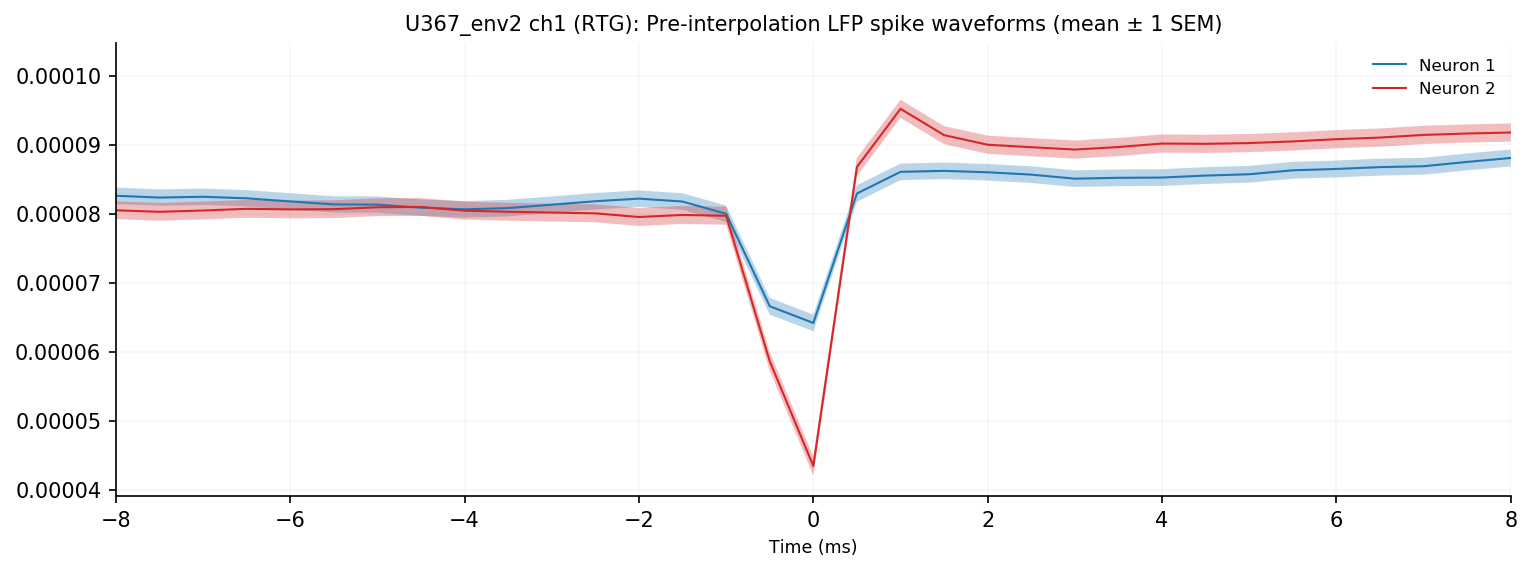

In [51]:
## Plot the mean LFP waveform after spike removal.

chan = '1'
n_clusters = n_clus_by_chan[chan]

spike_lfp_post = []
lfp_post = lfp_raw.sel(channel=chan).copy().data
for clus in range(n_clusters):
    spike_lfp_post.append([])
    for spike_time in session_spikes[chan]['spike_times'][clus]:
        spike_time = int(spike_time)
        if (spike_time > 16) and (spike_time < (len(lfp_post) - 16)):
            spike_lfp_post[clus].append(lfp_post[int(spike_time)-16:int(spike_time)+17])
    spike_lfp_post[clus] = np.array(spike_lfp_post[clus])

dat = []
for clus in range(n_clusters):
    dat.append(np.mean(spike_lfp_post[clus], axis=0))
    
dat = np.array(dat)
dat_min = np.min(dat)
dat_max = np.max(dat)
ymin = -1.1 * abs(dat_min)
ymax = 1.1 * abs(dat_max)
fig, ax = plot_trace(dat, x_units='ms', x_inds=np.arange(-8, 8.5, 0.5), 
                     linewidths=[1] * n_clusters, dpi=150,
                     legend_labels=['Neuron {}'.format(i+1) for i in range(n_clusters)],
                     title=('{} ch{} ({}): Pre-interpolation LFP spike waveforms (mean ± 1 SEM)'
                            .format(subj_sess, chan, session_spikes[chan]['location'])))

colors = ['C{}'.format(i) for i in range(n_clusters)]
for clus in range(n_clusters):
    ax[0].fill_between(np.arange(-8, 8.5, 0.5), 
                       (np.nanmean(spike_lfp_post[clus], axis=0) 
                        - stats.sem(spike_lfp_post[clus], axis=0)),
                       (np.nanmean(spike_lfp_post[clus], axis=0) 
                        + stats.sem(spike_lfp_post[clus], axis=0)),
                       facecolor=colors[clus], alpha=0.3, linewidth=0)
    
f = os.path.join(figure_dir, 'mean_LFP_waveform_preinterp_{}_{}_ch{}.png'.format(subj, sess, chan))
#fig.savefig(f)

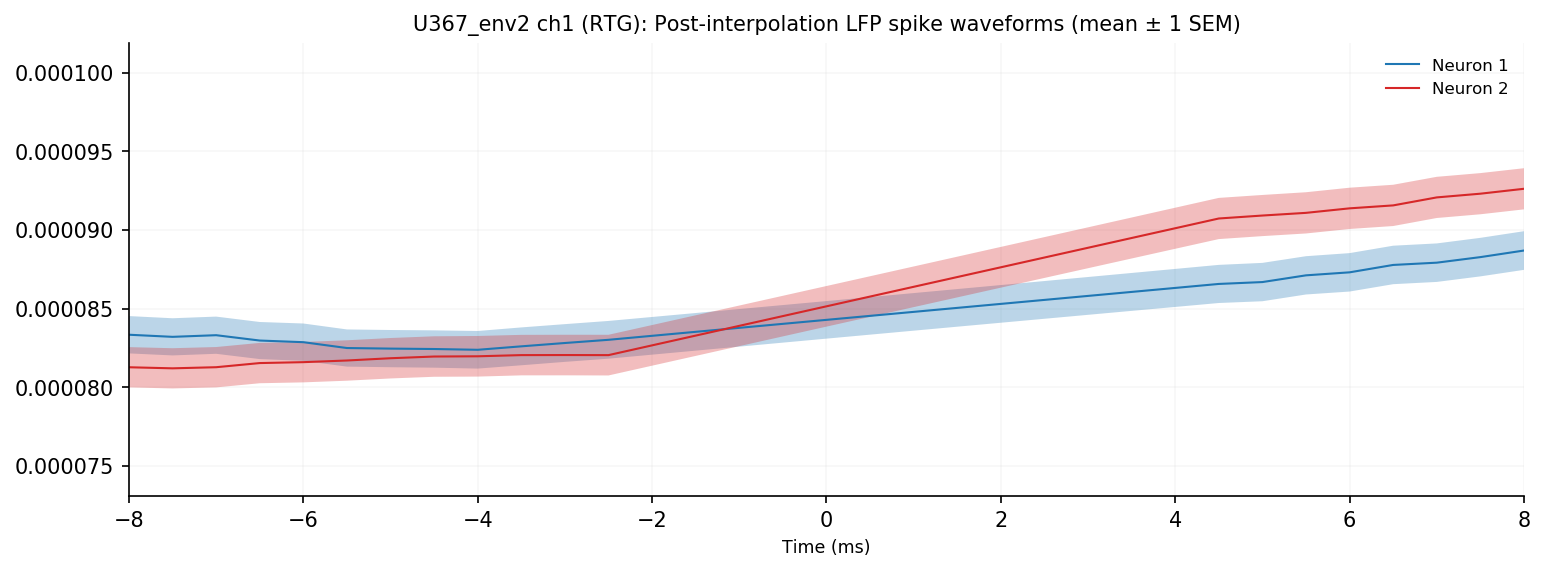

In [48]:
## Plot the mean LFP waveform after spike removal.

chan = '1'
n_clusters = n_clus_by_chan[chan]

spike_lfp_post = []
lfp_post = lfp_proc.sel(channel=chan).copy().data
for clus in range(n_clusters):
    spike_lfp_post.append([])
    for spike_time in session_spikes[chan]['spike_times'][clus]:
        spike_time = int(spike_time)
        if (spike_time > 16) and (spike_time < (len(lfp_post) - 16)):
            spike_lfp_post[clus].append(lfp_post[int(spike_time)-16:int(spike_time)+17])
    spike_lfp_post[clus] = np.array(spike_lfp_post[clus])

dat = []
for clus in range(n_clusters):
    dat.append(np.mean(spike_lfp_post[clus], axis=0))
    
dat = np.array(dat)
dat_min = np.min(dat)
dat_max = np.max(dat)
ymin = -1.1 * abs(dat_min)
ymax = 1.1 * abs(dat_max)
fig, ax = plot_trace(dat, x_units='ms', x_inds=np.arange(-8, 8.5, 0.5), 
                     linewidths=[1] * n_clusters, dpi=150,
                     legend_labels=['Neuron {}'.format(i+1) for i in range(n_clusters)],
                     title=('{} ch{} ({}): Post-interpolation LFP spike waveforms (mean ± 1 SEM)'
                            .format(subj_sess, chan, session_spikes[chan]['location'])))

colors = ['C{}'.format(i) for i in range(n_clusters)]
for clus in range(n_clusters):
    ax[0].fill_between(np.arange(-8, 8.5, 0.5), 
                       (np.nanmean(spike_lfp_post[clus], axis=0) 
                        - stats.sem(spike_lfp_post[clus], axis=0)),
                       (np.nanmean(spike_lfp_post[clus], axis=0) 
                        + stats.sem(spike_lfp_post[clus], axis=0)),
                       facecolor=colors[clus], alpha=0.3, linewidth=0)
    
f = os.path.join(figure_dir, 'mean_LFP_waveform_postinterp_{}_{}_ch{}.png'.format(subj, sess, chan))
#fig.savefig(f)

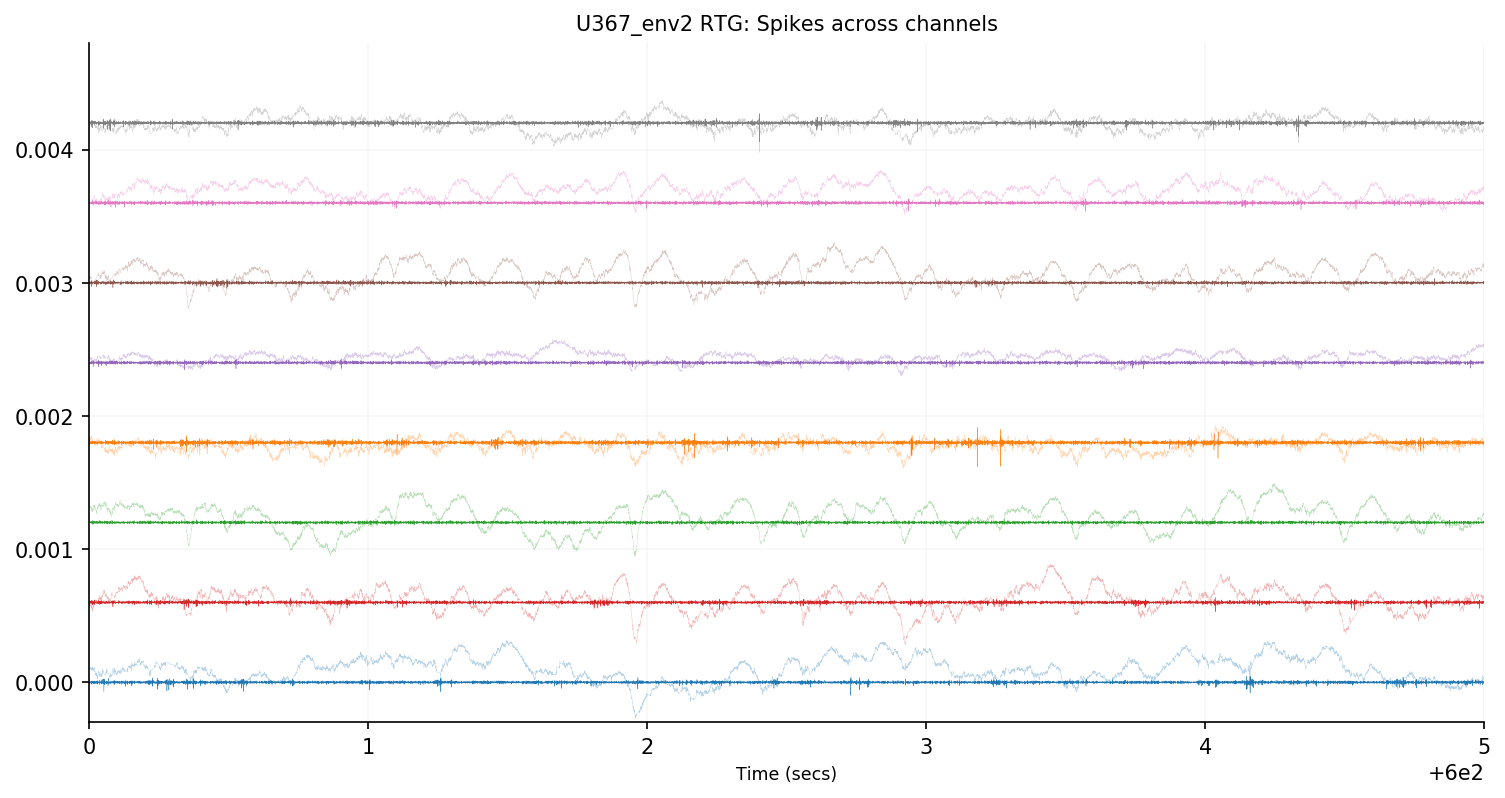

In [20]:
# Plot 
roi = 'RTG'
chans = roi_to_chan[roi]

dat = []
colors = []
alphas = []
linewidths = []
offset = 0.0006
for i, chan in enumerate(chans):
    lfp300 = mne.filter.filter_data(lfp_raw.sel(channel=chan).copy().data.astype(np.float64), 
                                    sfreq=2000, l_freq=300, h_freq=None, verbose=False)
    lfp300 += i * offset
    dat.append(lfp300)
    dat.append(lfp_proc.sel(channel=chan).copy().data + i * offset)
    colors += ['C{}'.format(i)] * 2
    alphas += [1, 0.33]
    linewidths += [0.2, 0.2]

dat = np.array(dat)

# for chan in chans:
#     if chan in n_clus_by_chan.keys():
#         n_clusters = n_clus_by_chan[chan]
#         for clus in range(n_clusters):
#             dat = np.vstack((dat, session_spikes[chan]['spikes'][clus]))
#             colors.append('C{}'.format(clus))
#             alphas.append(1)
#             markers.append('|')
#             markersizes.append(10)
#             markeredgewidths.append(0.8)
#             legend_labels.append('Neuron {}'.format(clus+1))

fig, ax = plot_trace(dat, start=600, duration=5, x_units='secs', figsize=(12, 6),
                     colors=colors, alphas=alphas, linewidths=linewidths,
                     title=('{} {}: Spikes across channels'
                            .format(subj_sess, roi)))

f = os.path.join(figure_dir, 'example_LFP_trace_pre_and_post_spike_removal_{}_{}_ch{}.png'.format(subj, sess, chan))
#fig.savefig(f)

Setting up high-pass filter at 3e+02 Hz
l_trans_bandwidth chosen to be 75.0 Hz
Filter length of 89 samples (0.044 sec) selected


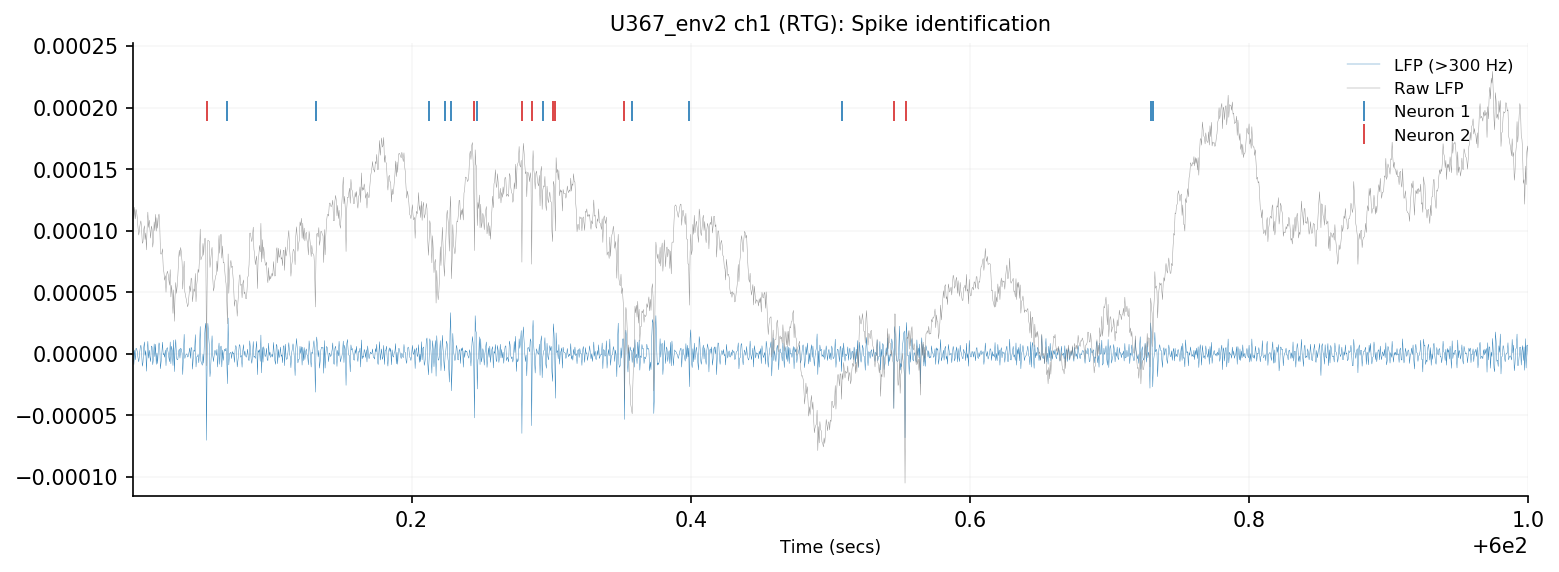

In [22]:
## Plot notch-filtered LFP before and after spike removal, and with a 300 Hz high pass 
# filter to pick out spikes.

chan = '1'
n_clusters = n_clus_by_chan[chan]

colors = ['C0', 'C7']
alphas = [1, 0.9]
markers = [None, None]
markersizes = [None, None]
markeredgewidths = [None, None]
legend_labels = ['LFP (>300 Hz)', 'Raw LFP']

lfp300 = mne.filter.filter_data(lfp_raw.sel(channel=chan).copy().data.astype(np.float64), 
                                sfreq=2000, l_freq=300, h_freq=None)
dat = np.vstack((lfp300, lfp_raw.sel(channel=chan).copy().data))

for clus in range(n_clusters):
    dat = np.vstack((dat, session_spikes[chan]['spikes'][clus]))
    colors.append('C{}'.format(clus))
    alphas.append(1)
    markers.append('|')
    markersizes.append(10)
    markeredgewidths.append(0.8)
    legend_labels.append('Neuron {}'.format(clus+1))
    
fig, ax = plot_trace(dat, start=600, duration=1, x_units='secs', 
                     colors=colors, alphas=alphas, linewidths=[0.2, 0.2], 
                     markers=markers, markersizes=markersizes, 
                     markeredgewidths=markeredgewidths, legend_labels=legend_labels,
                     title=('{} ch{} ({}): Spike identification'
                            .format(subj_sess, chan, session_spikes[chan]['location'])))

f = os.path.join(figure_dir, 'example_raw_LFP_trace_vs_300Hz_hipass_vs_spikes_{}_{}_ch{}.png'.format(subj, sess, chan))
#fig.savefig(f)

Setting up high-pass filter at 3e+02 Hz
l_trans_bandwidth chosen to be 75.0 Hz
Filter length of 89 samples (0.044 sec) selected
Setting up high-pass filter at 3e+02 Hz
l_trans_bandwidth chosen to be 75.0 Hz
Filter length of 89 samples (0.044 sec) selected


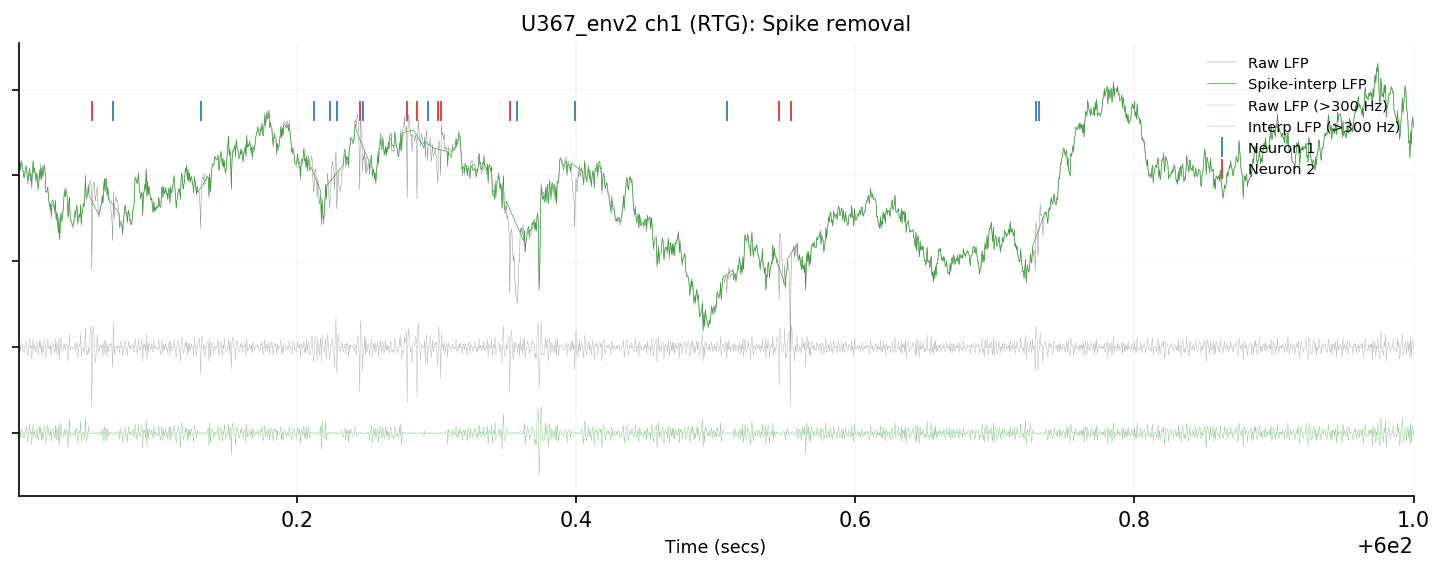

In [42]:
## Plot notch-filtered LFP before and after spike removal, and with a 300 Hz high pass 
# filter to pick out spikes.

chan = '1'
n_clusters = n_clus_by_chan[chan]

colors = ['C7', 'C2', 'C7', 'C2']
alphas = [1, 1, 0.6, 0.6]
linewidths = [0.2, 0.3, 0.2, 0.2]
markers = [None, None, None, None]
markersizes = [None, None, None, None]
markeredgewidths = [None, None, None, None]
legend_labels = ['Raw LFP', 'Spike-interp LFP', 'Raw LFP (>300 Hz)', 'Interp LFP (>300 Hz)']

lfp300 = mne.filter.filter_data(lfp_raw.sel(channel=chan).copy().data.astype(np.float64), 
                                sfreq=2000, l_freq=300, h_freq=None)
lfp300 = lfp300 - 1e-4
lfpproc300 = mne.filter.filter_data(lfp_proc.sel(channel=chan).copy().data.astype(np.float64), 
                                    sfreq=2000, l_freq=300, h_freq=None)
lfpproc300 = lfpproc300 - 2*1e-4
dat = np.vstack((lfp_raw.sel(channel=chan).copy().data, lfp_proc.sel(channel=chan).copy().data, lfp300, lfpproc300))

for clus in range(n_clusters):
    dat = np.vstack((dat, session_spikes[chan]['spikes'][clus]))
    colors.append('C{}'.format(clus))
    alphas.append(1)
    markers.append('|')
    markersizes.append(10)
    markeredgewidths.append(0.8)
    legend_labels.append('Neuron {}'.format(clus+1))
    
fig, ax = plot_trace(dat, start=600, duration=1, x_units='secs', 
                     colors=colors, alphas=alphas, linewidths=linewidths,
                     markers=markers, markersizes=markersizes, 
                     markeredgewidths=markeredgewidths, legend_labels=legend_labels, legend_size=7,
                     title=('{} ch{} ({}): Spike removal'
                            .format(subj_sess, chan, session_spikes[chan]['location'])))
ax[0].set_yticklabels([None])
f = os.path.join(figure_dir, 'example_LFP_trace_pre_and_post_spike_removal_{}_{}_ch{}.png'.format(subj, sess, chan))
#fig.savefig(f)

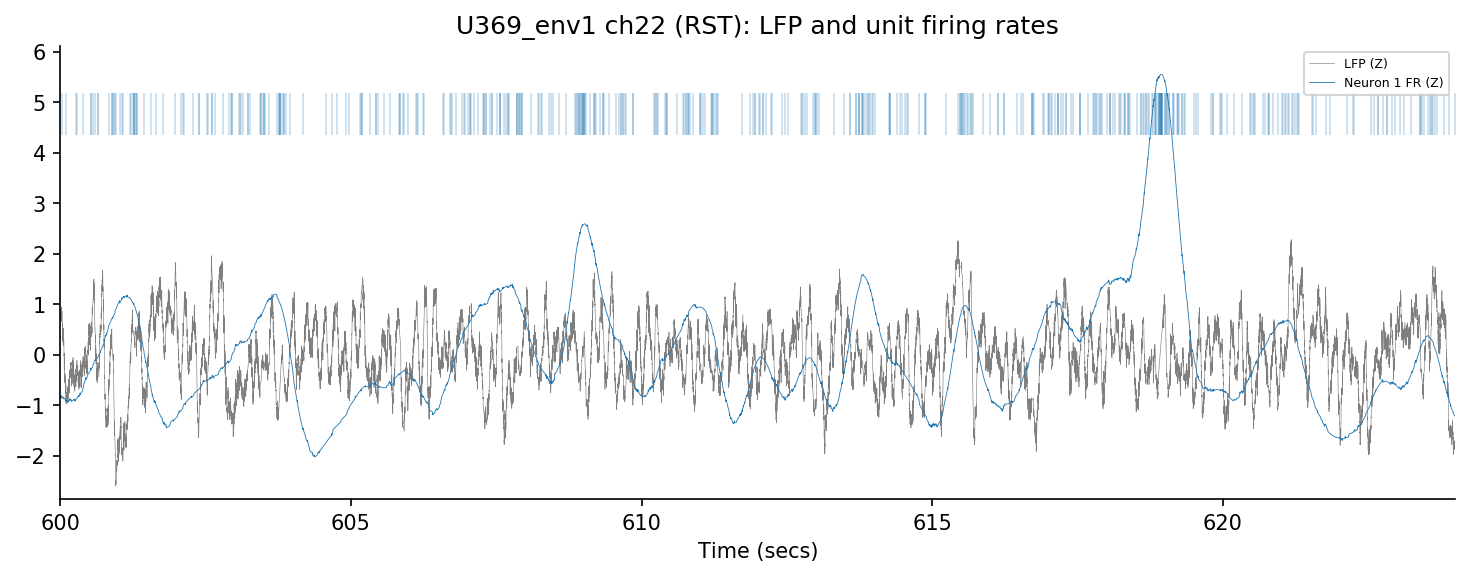

In [127]:
## Plot Z-scored versions of the processed LFP and unit firing rates.

i = 15 # the lfp_mne channel to display

chan = lfp_mne.ch_names[i]
ind = chan_to_ind[chan]
n_clusters = int(subj_df.at[ind, 'n_clusters'])
lfp_z = ((lfp_mne.get_data(picks=[i]).squeeze() - np.nanmean(lfp_mne.get_data(picks=[i]).squeeze())) 
         / np.nanstd(lfp_mne.get_data(picks=[i]).squeeze()))
dat = lfp_z
colors = ['C7']
alphas = [1]
linewidths = [0.3]
markers = [None]
legend_labels = ['LFP (Z)']

for clus in range(n_clusters):
    fr_z = ((session_spikes[chan]['fr'][clus] - np.nanmean(session_spikes[chan]['fr'][clus]))
            / np.nanstd(session_spikes[chan]['fr'][clus]))
    dat = np.vstack((dat, fr_z))
    colors.append('C{}'.format(clus))
    alphas.append(1)
    linewidths.append(0.4)
    markers.append(None)
    legend_labels.append('Neuron {} FR (Z)'.format(clus+1))
    
for clus in range(n_clusters):
    dat = np.vstack((dat, session_spikes[chan]['spikes'][clus]))
    colors.append('C{}'.format(clus))
    alphas.append(1)
    markers.append('|')
    
fig, ax = plot_trace(dat, start=600, duration=24, x_units='secs', 
                     colors=colors, alphas=alphas, 
                     linewidths=linewidths, markers=markers,
                     legend_labels=legend_labels, legend_size=6, 
                     title=('{}_{} ch{} ({}): LFP and unit firing rates'
                            .format(subj, sess, chan, subj_df.at[ind, 'location'])))

f = os.path.join(figure_dir, 'example_LFP_trace_with_unit_firing_overlaid_{}_{}_ch{}.png'.format(subj, sess, chan))
#fig.savefig(f)

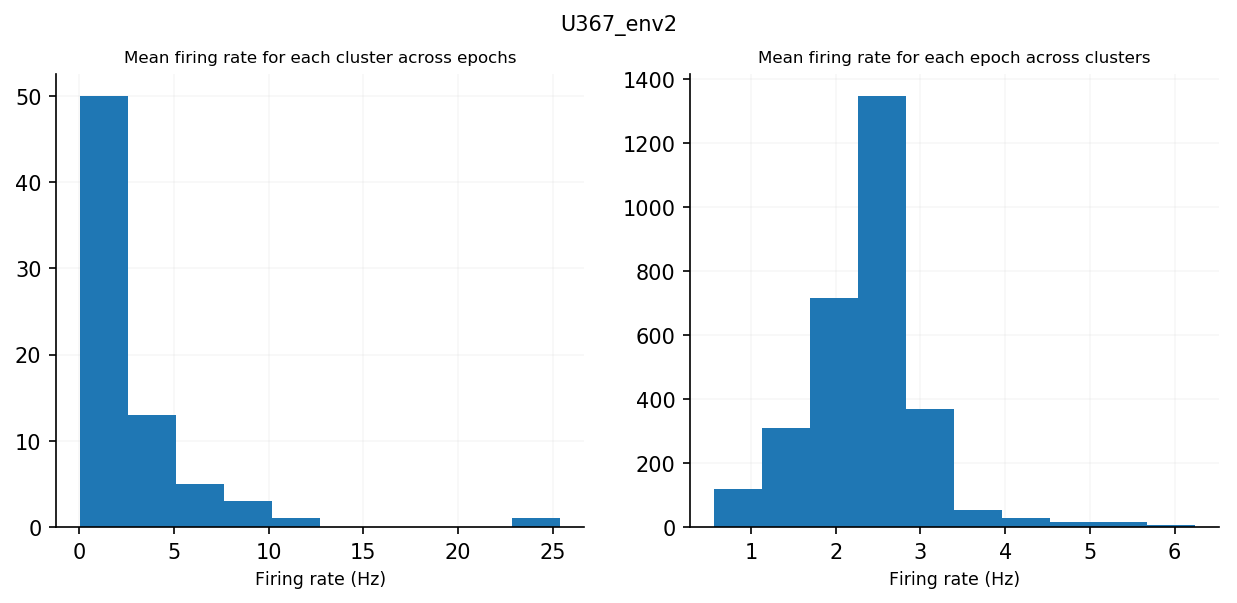

In [54]:
# Plot the mean firing rate for each cluster in the session, over epoch and over time. 

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax = np.ravel(ax)

ax[0].hist(epoch_fr.mean('epoch'))
ax[0].set_xlabel('Firing rate (Hz)')
ax[0].set_title('Mean firing rate for each cluster across epochs'.format(subj_sess), fontsize=8)

ax[1].hist(epoch_fr.mean('cluster'))
ax[1].set_xlabel('Firing rate (Hz)')
ax[1].set_title('Mean firing rate for each epoch across clusters'.format(subj_sess), fontsize=8)

fig.suptitle(subj_sess, fontsize=10)

f = os.path.join(figure_dir, 'mean_firing_rates_across_epoch_cluster_{}_{}.png'.format(subj, sess))
#fig.savefig(f)

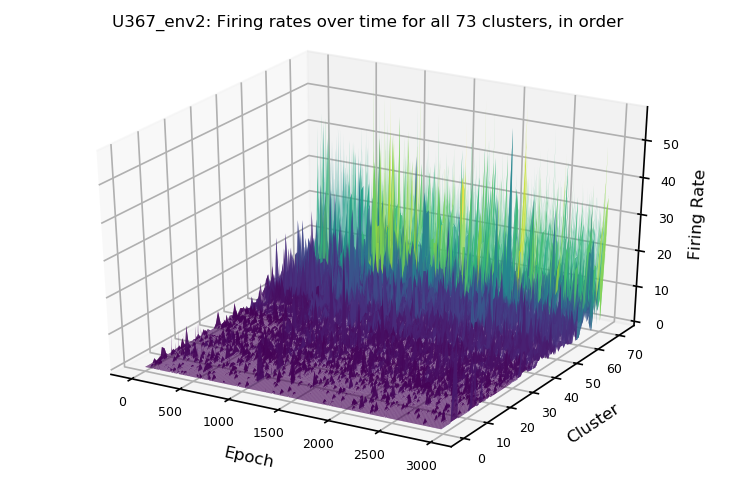

In [1374]:
# Plot the mean firing rate for each cluster in the session, over epoch and time. 

plt.close('all')
fig = plt.figure()
ax = fig.gca(projection='3d')

fr_sort_clus = epoch_fr.mean('epoch').data.argsort()
dat = epoch_fr[fr_sort_clus, :].data
#fr_sort_clus = epoch_fr.median('epoch').data.argsort()
#fr_sort_epoch = epoch_fr.median('cluster').data.argsort()
#dat = epoch_fr[fr_sort_clus, fr_sort_epoch].data

x = np.repeat(np.arange(dat.shape[0]), dat.shape[1])
y = np.tile(np.arange(dat.shape[1]), dat.shape[0])
z = dat.flatten()

#ax.plot_trisurf(x, y, z, cmap=plt.cm.CMRmap, linewidth=0.2, edgecolor='none')
#ax.contour3D(np.arange(dat.shape[1]), np.arange(dat.shape[0]), dat)
x, y = np.meshgrid(np.arange(dat.shape[1]), np.arange(dat.shape[0]))
ax.plot_surface(x, y, dat, cmap='viridis', alpha=0.75, rstride=10, cstride=10)
for item in ax.get_xticklabels() + ax.get_yticklabels() + ax.get_zticklabels():
    item.set_fontsize(6)
ax.tick_params(pad=-1)
ax.set_xlabel('Epoch', fontsize=8, labelpad=-1)
ax.set_ylabel('Cluster', fontsize=8, labelpad=-1)
ax.set_zlabel('Firing Rate', fontsize=8, labelpad=-5)
ax.set_title('{}: Firing rates over time for all {} clusters, in order'.format(subj_sess, len(epoch_fr.cluster)), 
             fontsize=8, pad=15)

f = os.path.join(figure_dir, '{}_epoch_firing_rates_over_time.png'.format(subj_sess))
#fig.savefig(f)

In [1386]:
corr, pval = stats.spearmanr(fr_dat[clus, :], bband_dat[clus, :])

(-0.014834889545097851, 0.4179747331255408)

In [170]:
bband_dat = epoch_band_power.copy().sel(freq='bband_power', channel=chans)[:, :].data

fr_dat = epoch_fr.copy().data
bband_dat.shape, fr_dat.shape

((8, 2983), (73, 2983))

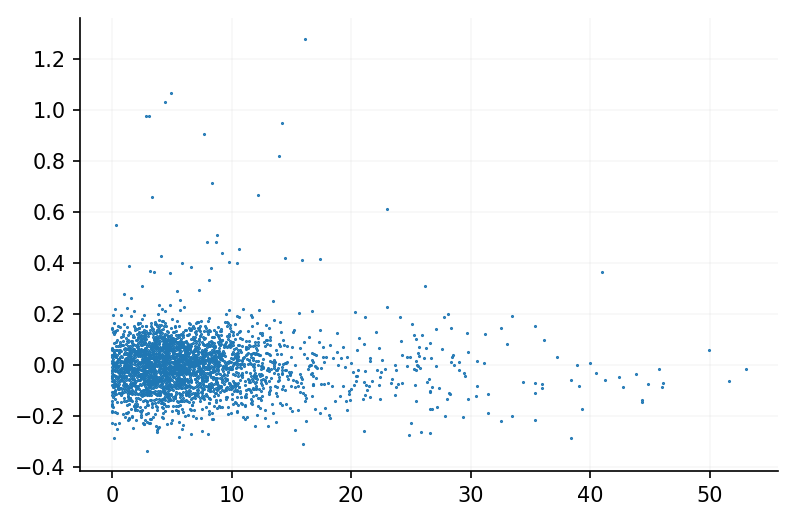

In [173]:
fr_dat = epoch_fr.copy().data
chans = [clus_to_chan[clus] for clus in epoch_fr.cluster.data]
bband_dat = epoch_band_power.copy().sel(freq='bband_power', channel=chans)[:, :].data

chan = chans[0]

plt.plot(fr_dat[0, :], bband_dat[0, :], linewidth=0, marker='.', markersize=1)

(array([60.,  1.,  3.,  1.,  3.,  0.,  1.,  0.,  2.,  2.]),
 array([8.07147310e-67, 9.46648381e-02, 1.89329676e-01, 2.83994514e-01,
        3.78659352e-01, 4.73324190e-01, 5.67989028e-01, 6.62653866e-01,
        7.57318705e-01, 8.51983543e-01, 9.46648381e-01]),
 <a list of 10 Patch objects>)

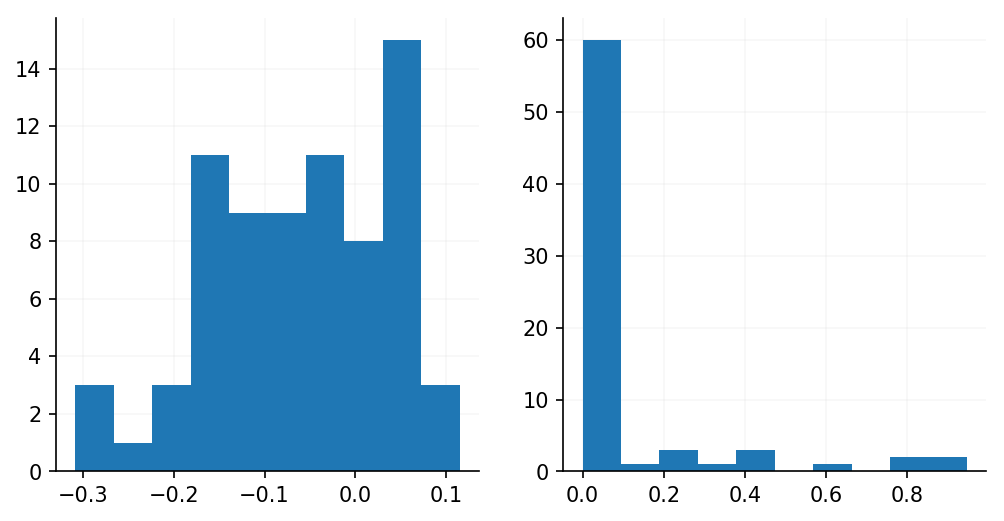

In [42]:
# fr_sort_clus = epoch_fr.mean('epoch').data.argsort()
# fr_dat = epoch_fr[fr_sort_clus, :].data
# sorted_chans = [clus_to_chan[clus] for clus in epoch_fr[fr_sort_clus, :].cluster.data]

fr_dat = epoch_fr.copy().data
chans = [clus_to_chan[clus] for clus in epoch_fr.cluster.data]
bband_dat = epoch_band_power.copy().sel(freq='bband_power', channel=chans)[:, :].data

corrs = []
pvals = []
for clus in range(fr_dat.shape[0]):
    #corr, pval = stats.spearmanr(np.roll(fr_dat[clus, :], int(np.random.rand() * fr_dat.shape[1])), bband_dat[clus, :])
    corr, pval = stats.spearmanr(fr_dat[clus, :], bband_dat[clus, :])
    corrs.append(corr)
    pvals.append(pval)
    
fig, ax = plt.subplots(1, 2, dpi=150, figsize=(8, 4))
ax = np.ravel(ax)
ax[0].hist(corrs)
ax[1].hist(pvals)

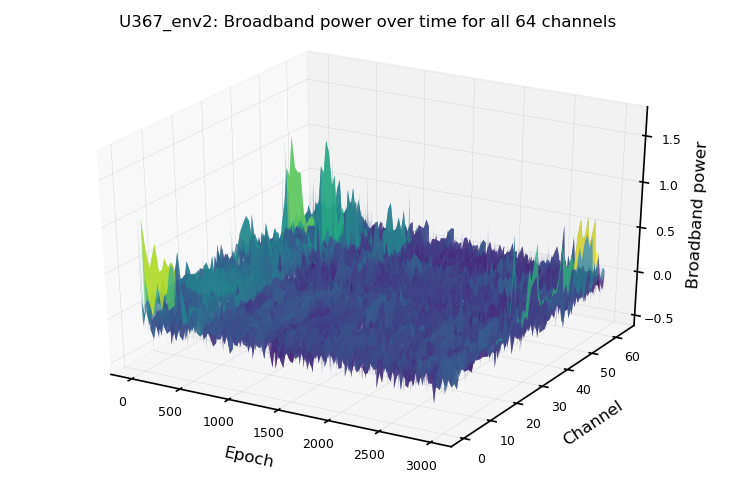

In [36]:
plt.close('all')
fig = plt.figure()
ax = fig.gca(projection='3d')

dat = epoch_band_power.copy().sel(freq='bband_power')[:, :].data

x = np.repeat(np.arange(dat.shape[0]), dat.shape[1])
y = np.tile(np.arange(dat.shape[1]), dat.shape[0])
z = dat.flatten()

#ax.plot_trisurf(x, y, z, cmap=plt.cm.CMRmap, linewidth=0.2, edgecolor='none')
#ax.contour3D(np.arange(dat.shape[1]), np.arange(dat.shape[0]), dat)
x, y = np.meshgrid(np.arange(dat.shape[1]), np.arange(dat.shape[0]))
ax.plot_surface(x, y, dat, cmap='viridis', alpha=0.75, rstride=10, cstride=10)
for item in ax.get_xticklabels() + ax.get_yticklabels() + ax.get_zticklabels():
    item.set_fontsize(6)
ax.tick_params(pad=-1)
ax.set_xlabel('Epoch', fontsize=8, labelpad=-1)
ax.set_ylabel('Channel', fontsize=8, labelpad=-1)
ax.set_zlabel('Broadband power', fontsize=8, labelpad=-5)
ax.set_title('{}: Broadband power over time for all {} channels'.format(subj_sess, len(epoch_band_power.channel)), 
             fontsize=8, pad=15)

f = os.path.join(figure_dir, '{}_epoch_bband_power_over_time_sorted_by_FR.png'.format(subj_sess))
#fig.savefig(f)

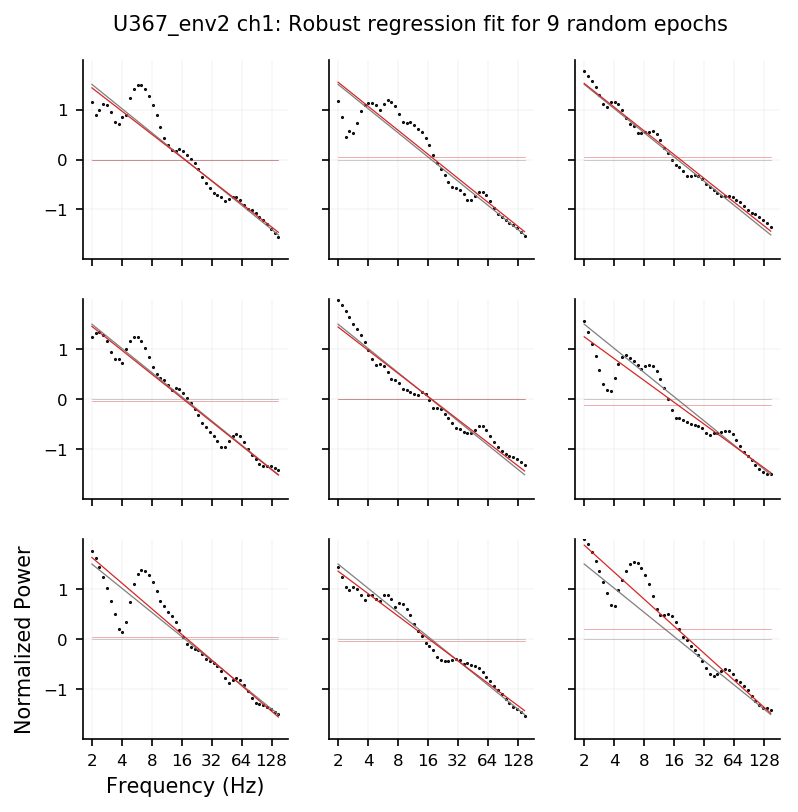

In [81]:
chan = '1'
epochs = [int(i) for i in np.random.rand(9) * len(epoch_power.epoch)]
dat = epoch_power.sel(channel=chan, epoch=epochs).data

X = sm.add_constant(np.log10(freqs))
mean_intercept = epoch_band_power.sel(freq='intercept', channel=chan).data.mean()
mean_bband_tilt = epoch_band_power.sel(freq='bband_tilt', channel=chan).data.mean()
mean_pred = np.dot(X, [mean_intercept, mean_bband_tilt])

fig, ax = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(6, 6))
ax = ax.ravel()
for i in range(9):
    pred = np.dot(X, epoch_band_power.sel(channel=chan, epoch=epochs[i]).data[5:7])
    ax[i].plot(np.log10(freqs), dat[i, :], color='k', linewidth=0, marker='.', markersize=1)
    ax[i].plot(np.log10(freqs), mean_pred, color='C7', linewidth=0.6)
    ax[i].plot(np.log10(freqs), np.repeat(np.mean(mean_pred), len(freqs)), 
               color='C7', linewidth=0.3, alpha=0.6)
    ax[i].plot(np.log10(freqs), pred, color='C1', linewidth=0.6)
    ax[i].plot(np.log10(freqs), np.repeat(np.mean(pred), len(freqs)), 
               color='C1', linewidth=0.3, alpha=0.6)
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    ax[i].set_xticks(np.log10([2, 4, 8, 16, 32, 64, 128]))
    ax[i].set_xticklabels([2, 4, 8, 16, 32, 64, 128])
    ax[i].set_yticks([-1, 0, 1])
    ax[i].set_ylim([-2, 2])
    for item in ax[i].get_xticklabels() + ax[i].get_yticklabels():
        item.set_fontsize(8)
    for item in (ax[i].xaxis.label, ax[i].yaxis.label):
        item.set_fontsize(10)
    if i == 6:
        ax[i].set_xlabel('Frequency (Hz)')
        ax[i].set_ylabel('Normalized Power')
fig.suptitle('{} ch{}: Robust regression fit for 9 random epochs'.format(subj_sess, chan), 
             y=0.93, fontsize=10)

f = os.path.join(figure_dir, 'robust_regression_results_9epochs_{}_{}_ch{}.png'.format(subj, sess, chan))
#fig.savefig(f)

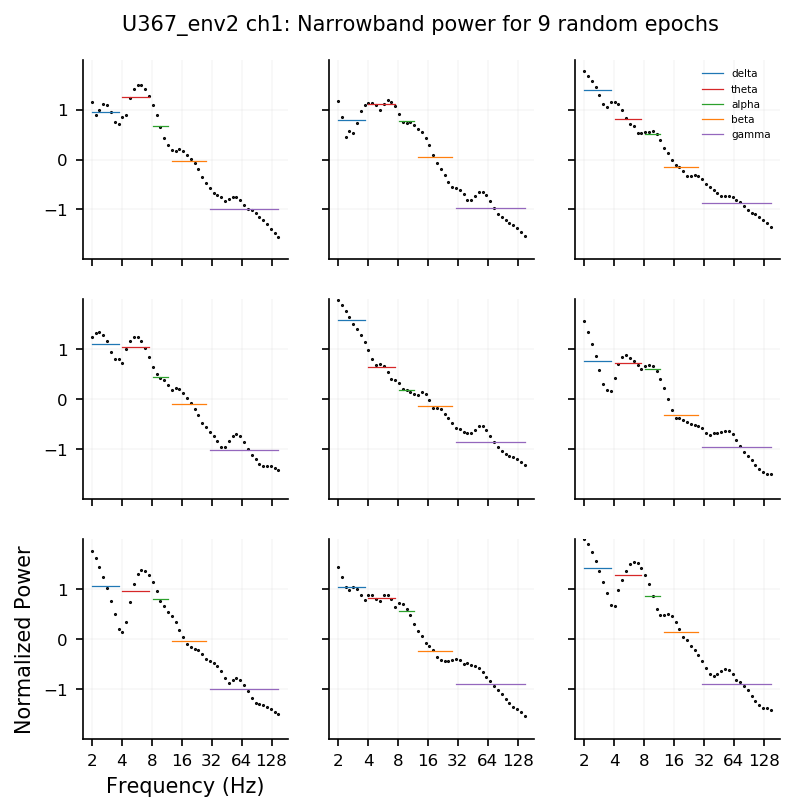

In [82]:
chan = '1'
#epochs = [int(i) for i in np.random.rand(9) * len(epoch_power.epoch)]
dat = epoch_power.sel(channel=chan, epoch=epochs).data
mean_pred = np.dot(X, [mean_bband_power, mean_bband_tilt])
narrowband_xvals = np.array([np.mean(np.log10(freq_bands[i])) for i in freq_bands.keys()])
narrowband_xvals = [np.log10(freq_bands[key]) for key in freq_bands.keys()]

fig, ax = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(6, 6))
ax = ax.ravel()
for i in range(9):
    ax[i].plot(np.log10(freqs), dat[i, :], color='k', linewidth=0, marker='.', markersize=1)
    narrowband_yvals = epoch_band_power.sel(channel=chan, epoch=epochs[i]).data[:5]
    for j in range(5):
        ax[i].plot(narrowband_xvals[j], np.repeat(narrowband_yvals[j], len(narrowband_xvals[j])), 
                   color='C{}'.format(j), linewidth=0.6, label=list(freq_bands.keys())[j])
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    ax[i].set_xticks(np.log10([2, 4, 8, 16, 32, 64, 128]))
    ax[i].set_xticklabels([2, 4, 8, 16, 32, 64, 128])
    ax[i].set_yticks([-1, 0, 1])
    ax[i].set_ylim([-2, 2])
    for item in ax[i].get_xticklabels() + ax[i].get_yticklabels():
        item.set_fontsize(8)
    for item in (ax[i].xaxis.label, ax[i].yaxis.label):
        item.set_fontsize(10)
    if i == 6:
        ax[i].set_xlabel('Frequency (Hz)')
        ax[i].set_ylabel('Normalized Power')
    if i == 2:
        ax[i].legend(loc=1, prop={'size': 5}, edgecolor='w')
fig.suptitle('{} ch{}: Narrowband power for 9 random epochs'.format(subj_sess, chan), 
             y=0.93, fontsize=10)

f = os.path.join(figure_dir, 'narrowband_power_results_9epochs_{}_{}_ch{}.png'.format(subj, sess, chan))
#fig.savefig(f)

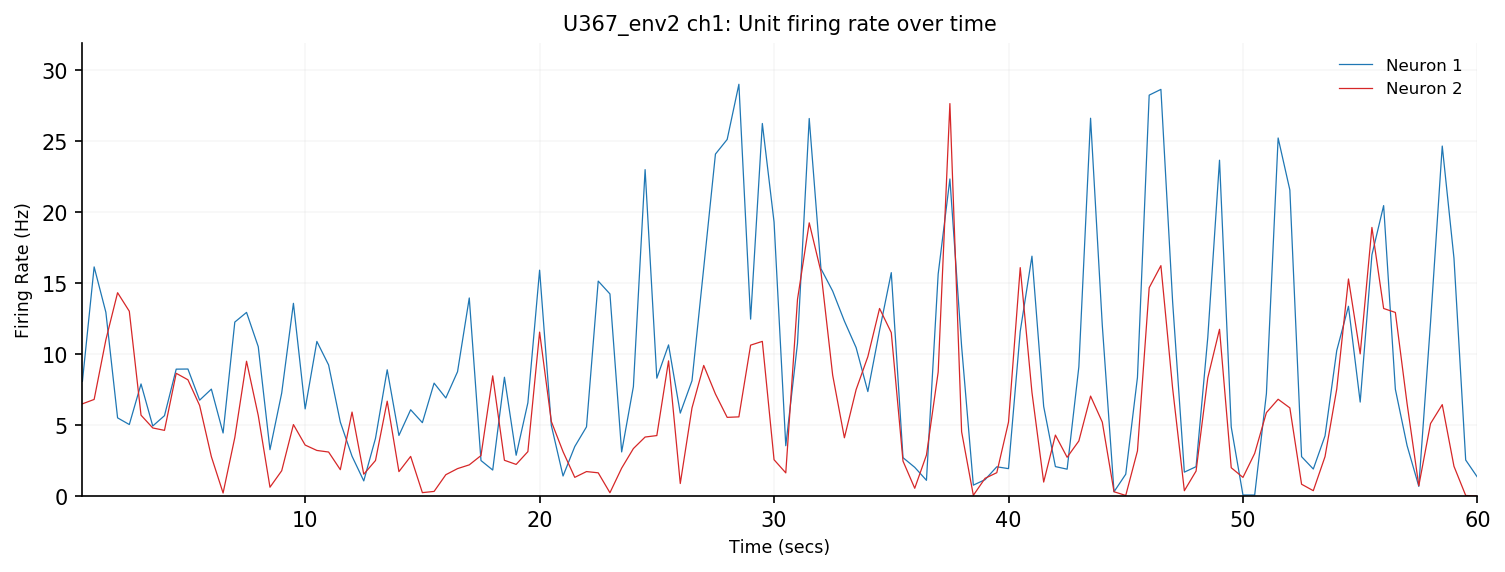

In [43]:
fig, ax = plot_trace(epoch_fr.data[:2, :], x_units='secs', sampling_rate=2, start=0, duration=60,
                     linewidths=[0.6, 0.6], y_lab='Firing Rate (Hz)', 
                     legend_labels=['Neuron 1', 'Neuron 2'],
                     title='{} ch{}: Unit firing rate over time'.format(subj_sess, chan))

f = os.path.join(figure_dir, 'example_unit_firing_over_time_{}_{}_ch{}.png'.format(subj, sess, chan))
#fig.savefig(f)

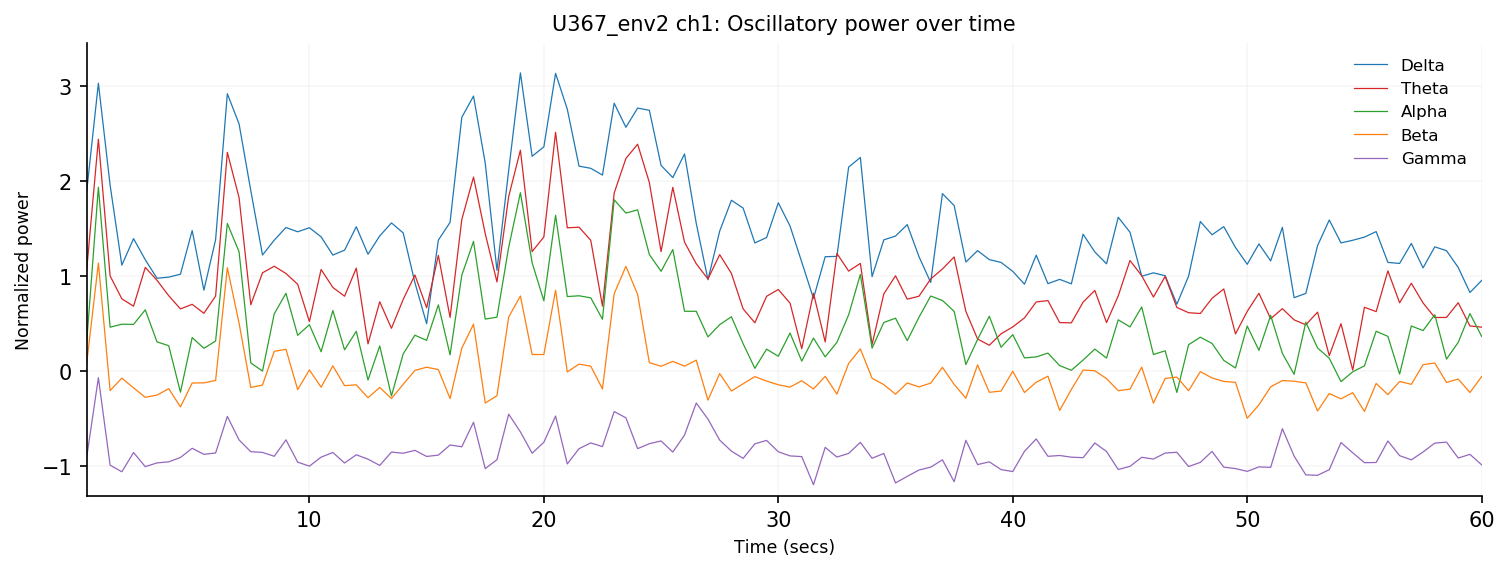

In [44]:
fig, ax = plot_trace(epoch_band_power.data[:1, :, :5], x_units='secs', sampling_rate=2, start=0, duration=60,
                     y_lab='Normalized power', linewidths=[0.6, 0.6, 0.6, 0.6, 0.6],
                     legend_labels=['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma'], 
                     title='{} ch{}: Oscillatory power over time'.format(subj_sess, chan))

f = os.path.join(figure_dir, 'example_normalized_power_over_time_{}_{}_ch{}.png'.format(subj, sess, chan))
#fig.savefig(f)

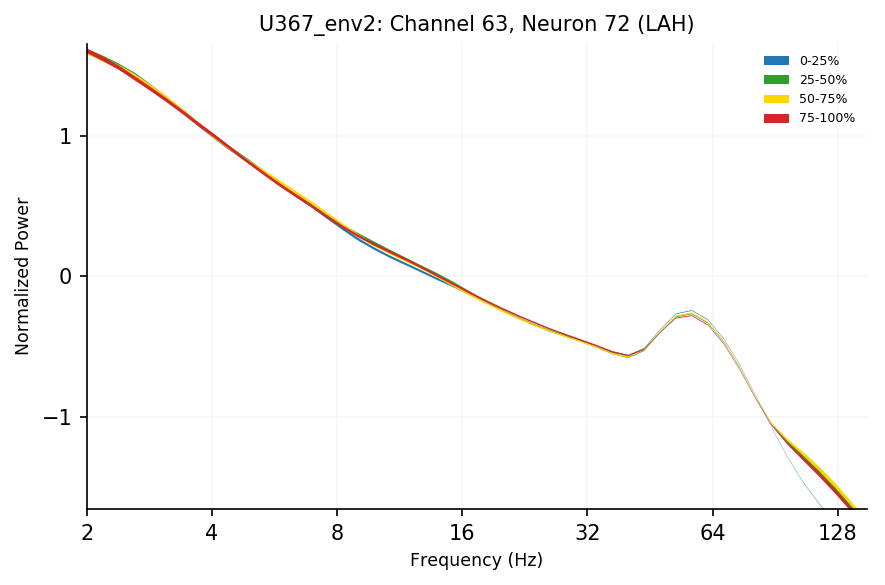

In [116]:
#clus = 6

for clus in range(epoch_fr.shape[0]):
    plt.close('all')
    fr_order = np.argsort(epoch_fr[clus, :]).data
    fr_order = fr_order[:int(len(fr_order) * 0.99)] # remove epochs in the top 1% of firing rates
    cut25 = int(round(len(fr_order) * 0.25, 0))
    cut50 = int(round(len(fr_order) * 0.50, 0))
    cut75 = int(round(len(fr_order) * 0.75, 0))
    fr_bins = [fr_order[:cut25], fr_order[cut25:cut50], fr_order[cut50:cut75], fr_order[cut75:]]
    epoch_dat = epoch_power.copy().sel(channel=clus_to_chan[clus]).data
    dat = np.vstack((np.mean(epoch_dat[fr_bins[0], :], axis=0),
                     np.mean(epoch_dat[fr_bins[1], :], axis=0),
                     np.mean(epoch_dat[fr_bins[2], :], axis=0),
                     np.mean(epoch_dat[fr_bins[3], :], axis=0)))

    colors = ['C0', 'C2', 'Gold', 'C1']
    fig, ax = plot_trace(dat, x_units='samples', x_inds=np.log10(freqs),
                         linewidths=[0]*4, colors=colors,
                         figsize=[6, 4], 
                         title=('{}: Channel {}, Neuron {} ({})'
                                .format(subj_sess, clus_to_chan[clus], clus, 
                                        fr_df.loc[fr_df.clus==clus, 'location'].iat[0])))
    legend_labels = {0: '0-25%', 1: '25-50%', 2: '50-75%', 3: '75-100%'}
    for i in range(4):
        ax[0].fill_between(np.log10(freqs), 
                           (np.mean(epoch_dat[fr_bins[i], :], axis=0) 
                            - stats.sem(epoch_dat[fr_bins[i], :], axis=0)),
                           (np.mean(epoch_dat[fr_bins[i], :], axis=0) 
                            + stats.sem(epoch_dat[fr_bins[i], :], axis=0)),
                           color=colors[i], alpha=1, linewidth=0, label=legend_labels[i])
    ax[0].legend(loc=1, prop={'size': 6}, edgecolor='w')
    # ax[0].set_xticks(np.log10([2, 15, 150]))
    # ax[0].set_xticklabels([2, 15, 150])
    ax[0].set_xticks(np.log10([2, 4, 8, 16, 32, 64, 128]))
    ax[0].set_xticklabels([2, 4, 8, 16, 32, 64, 128])
    ax[0].set_yticks([-1, 0, 1])
    ax[0].set_ylim([-1.66, 1.66])
    ax[0].set_xlabel('Frequency (Hz)')
    ax[0].set_ylabel('Normalized Power')
    fig.tight_layout(h_pad=1, w_pad=1)

    f = os.path.join(figure_dir, 'power_by_fr_{}_chan{}_neuron{}_{}.png'
                     .format(subj_sess, chan, clus, fr_df.loc[fr_df.clus==clus, 'location'].iat[0]))
    fig.savefig(f)

Text(0,0.5,'Firing Rate (Hz)')

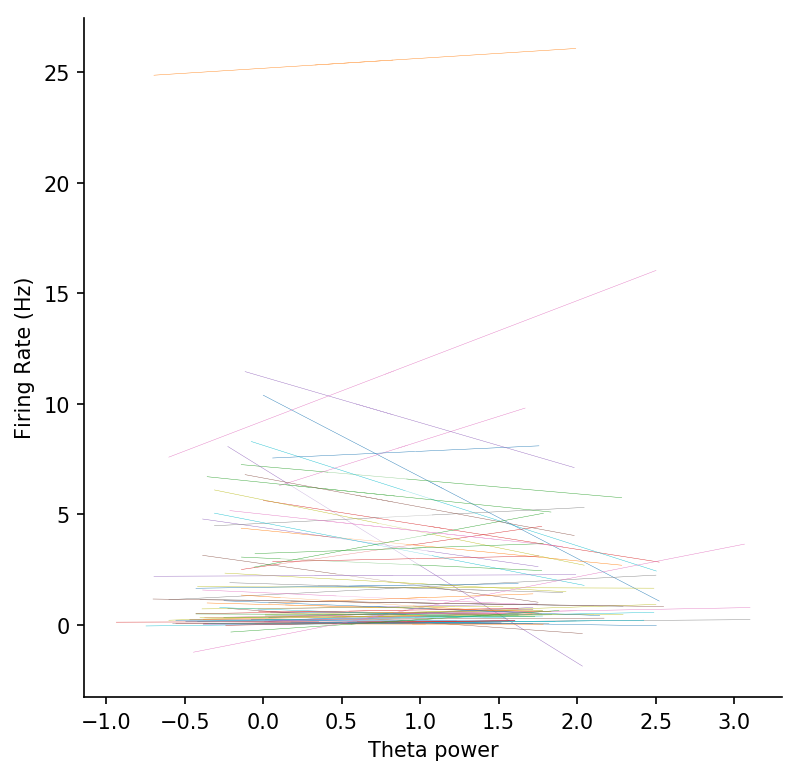

In [972]:
fr_by_band_dat = fr_by_band.data
xvals = np.arange(len(fr_by_band.epoch))

fig, ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(6, 6))
ax = np.ravel(ax)

iband = 2
for clus in range(len(fr_by_band.cluster)):
    X = sm.add_constant(fr_by_band_dat[iband, clus, :])
    y = fr_by_band_dat[0, clus, :]
    model = sm.OLS(y, X)
    results = model.fit()
    ax[0].plot(fr_by_band_dat[iband, clus, :], results.predict(), linewidth=0.2, alpha=0.5)

ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[0].set_xlabel('Theta power')
ax[0].set_ylabel('Firing Rate (Hz)')

Text(0,0.5,'Firing Rate (Hz)')

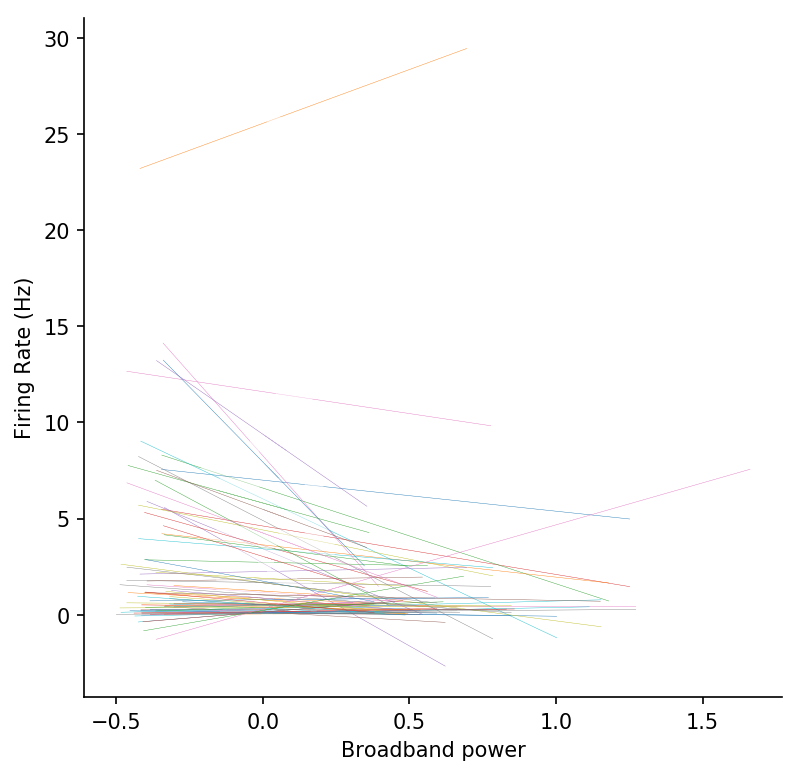

In [974]:
fr_by_band_dat = fr_by_band.data
xvals = np.arange(len(fr_by_band.epoch))

fig, ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(6, 6))
ax = np.ravel(ax)

for clus in range(len(fr_by_band.cluster)):
    X = sm.add_constant(fr_by_band_dat[-1, clus, :])
    y = fr_by_band_dat[0, clus, :]
    model = sm.OLS(y, X)
    results = model.fit()
    ax[0].plot(fr_by_band_dat[-1, clus, :], results.predict(), linewidth=0.2, alpha=0.5)
    #ax[0].plot(fr_by_band_dat[0, clus, :], fr_by_band_dat[-1, clus, :], marker='.', markersize=2, linewidth=0, alpha=0.3)

ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[0].set_xlabel('Broadband power')
ax[0].set_ylabel('Firing Rate (Hz)')

## Plots that have fallen out of favor with their maker

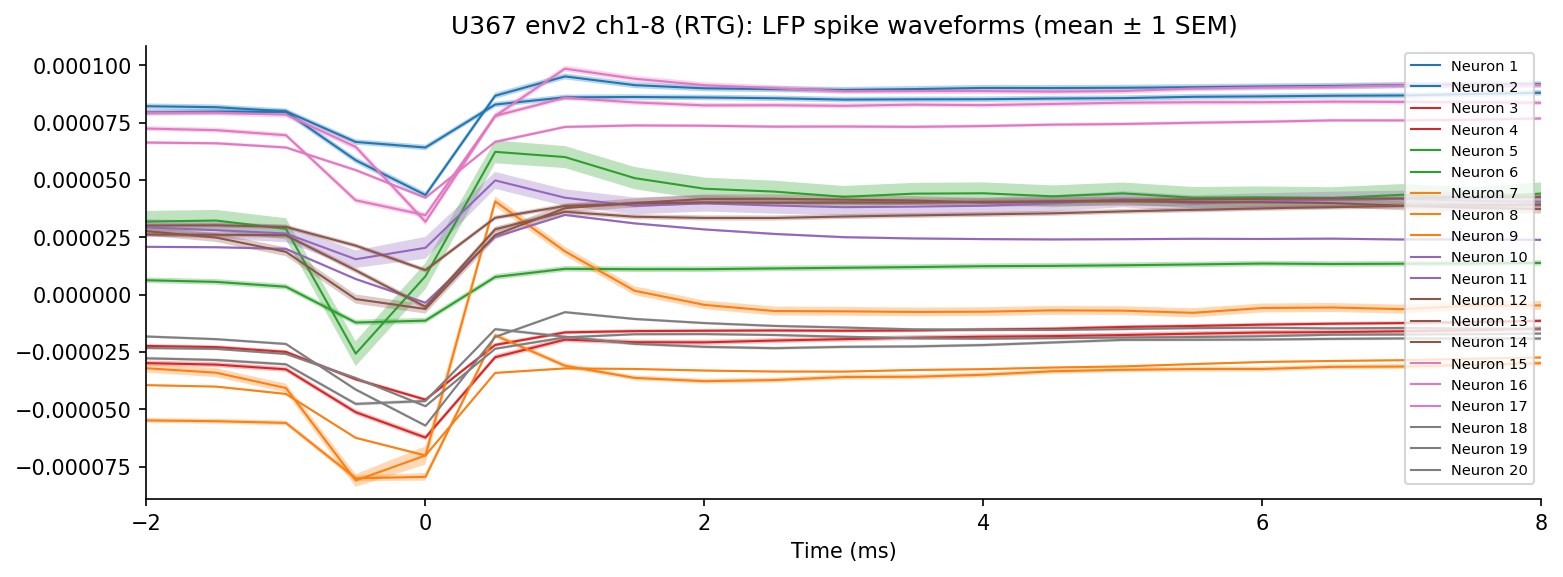

In [217]:
## Plot the mean LFP waveform for all clusters in the 
# first microwire bundle for U367-env2-1.

dat = []
colors = []
n_clusters = 0
for i in range(8): # look at the first 8 channels
    chan = lfp_mne.ch_names[i]
    ind = ch_to_ind[chan]
    chan_clusters = int(subj_df.at[ind, 'n_clusters'])
    n_clusters += chan_clusters
    colors += ['C{}'.format(i)] * chan_clusters
    for clus in range(chan_clusters):
        dat.append(np.nanmean(session_spikes[chan]['spike_lfp'][clus], axis=0))
    
dat = np.array(dat)
dat_min = np.min(dat)
dat_max = np.max(dat)
ymin = -1.1 * abs(dat_min)
ymax = 1.1 * abs(dat_max)
fig, ax = plot_trace(dat, x_units='ms', x_inds=np.arange(-2, 8.5, 0.5), 
                     linewidths=[1] * n_clusters, colors=colors,
                     legend_labels=['Neuron {}'.format(i+1) for i in range(n_clusters)],
                     legend_size=7,
                     title=('{} {} ch1-8 ({}): LFP spike waveforms (mean ± 1 SEM)'
                            .format(subj, sess, subj_df.at[ind, 'location'])))

colors = ['C{}'.format(i) for i in range(n_clusters)]
for i in range(8):
    chan = lfp_mne.ch_names[i]
    ind = ch_to_ind[chan]
    chan_clusters = int(subj_df.at[ind, 'n_clusters'])
    for clus in range(chan_clusters):
        ax[0].fill_between(np.arange(-2, 8.5, 0.5), 
                           (np.nanmean(session_spikes[chan]['spike_lfp'][clus], axis=0) 
                            - stats.sem(session_spikes[chan]['spike_lfp'][clus], axis=0)),
                           (np.nanmean(session_spikes[chan]['spike_lfp'][clus], axis=0) 
                            + stats.sem(session_spikes[chan]['spike_lfp'][clus], axis=0)),
                           facecolor='C{}'.format(i), alpha=0.3, linewidth=0)

## Proof of point tests

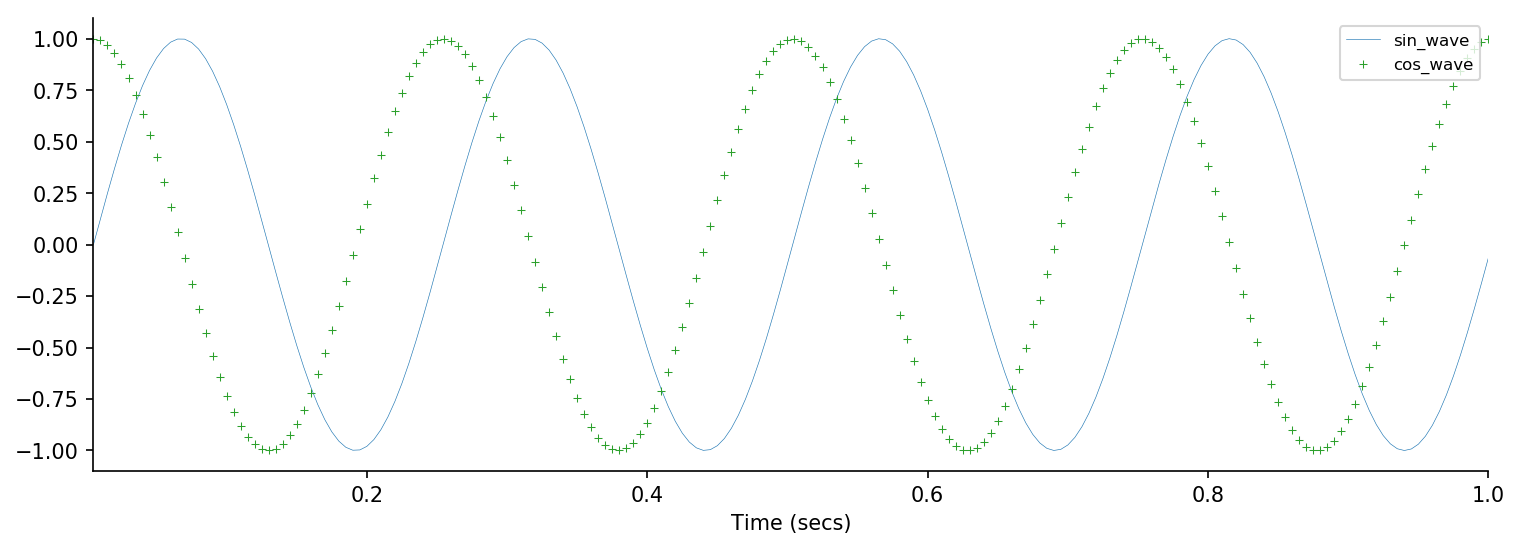

In [220]:
## Docstring example for plot_trace()

freq = 4
sampling_rate = 200
duration = 2
n_samples = sampling_rate * duration
sin_wave = np.sin(np.linspace(-np.pi, np.pi, n_samples) * duration * freq)
cos_wave = np.cos(np.linspace(-np.pi, np.pi, n_samples) * duration * freq)
dat = np.vstack((sin_wave, cos_wave))

# Plot the first 1 sec of data 
fig, ax = plot_trace(dat, start=0, duration=1, x_units='secs', 
                     sampling_rate=sampling_rate, colors=['C0', 'C2'], 
                     markers=[None, '+'], 
                     legend_labels=['sin_wave', 'cos_wave']) 

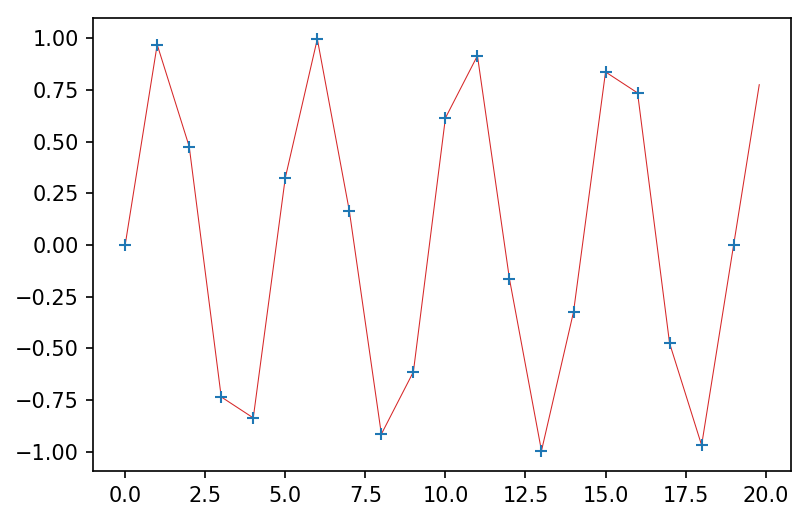

In [224]:
## Interpolation at its simplest (original points in blue, interpolated points in red).

y = np.array([np.sin(2 * np.pi * 4 * t) for t in np.linspace(0, 1, 20)])
x = np.arange(len(y))
f = interp1d(x, y, kind='linear', fill_value='extrapolate')
xnew = np.arange(0, len(y), 0.2)
ynew = f(xnew)
plt.close('all')
plt.plot(xnew, ynew, color='C1', linewidth=0.5)
plt.plot(x, y, '+') 

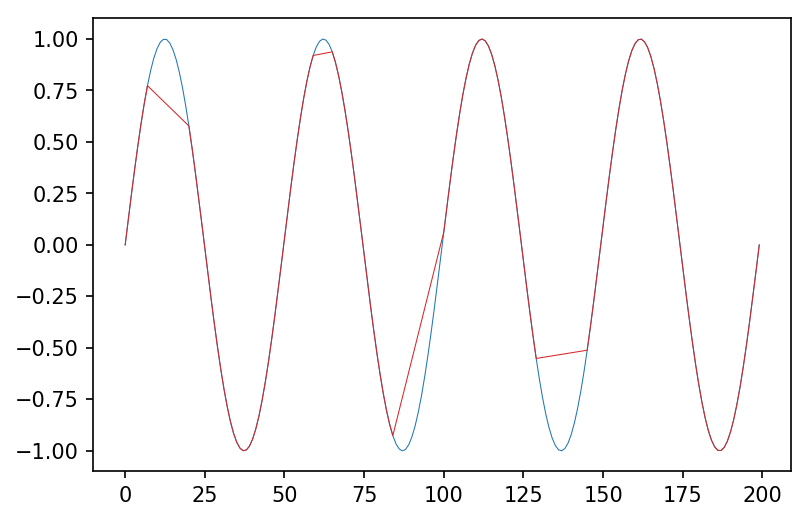

In [225]:
## Proof that interpolation works when we replace values
# (original points in blue, interpolated points in red).

v = np.array([np.sin(2 * np.pi * 4 * t) for t in np.linspace(0, 1, 200)])
mask = np.zeros(len(v), dtype='bool_')
mask[np.concatenate((np.arange(8, 20), np.arange(60, 65), np.arange(85, 100), np.arange(130, 145)))] = 1
keep_inds = np.where(mask==0)[0]
fill_inds = np.where(mask==1)[0]
f = interp1d(keep_inds, v[keep_inds], kind='linear', fill_value='extrapolate')
vnew = v.copy()
vnew[fill_inds] = f(fill_inds)

plt.close('all')
plt.plot(np.arange(len(v)), v, linewidth=0.5)
plt.plot(np.arange(len(v)), vnew, linewidth=0.5, color='C1')

Effective window size : 1.024 (s)
Need more than one channel to make topography for seeg. Disabling interactivity.


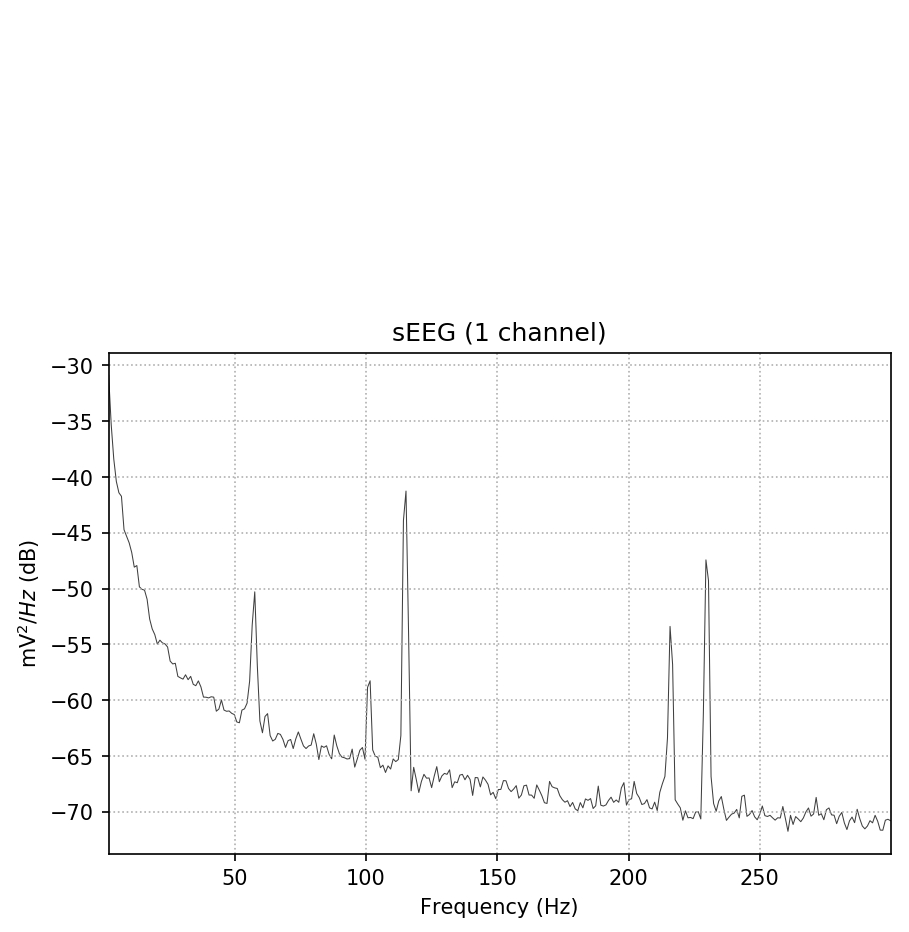

In [230]:
## Here we have a black boxy MNE implementation of power spectral density
# for the first 60 secs of notch-filtered, spike-removed LFP data.

fig = lfp_mne.plot_psd(tmin=0, tmax=60, fmin=1, fmax=300, n_fft=2048, picks=[4])

(0.0004997501249375312,
 0.0002911956476271664,
 1.0,
 (2001,),
 0.4995302518582929,
 0.4995302518582929,
 0.0009394962834141706)

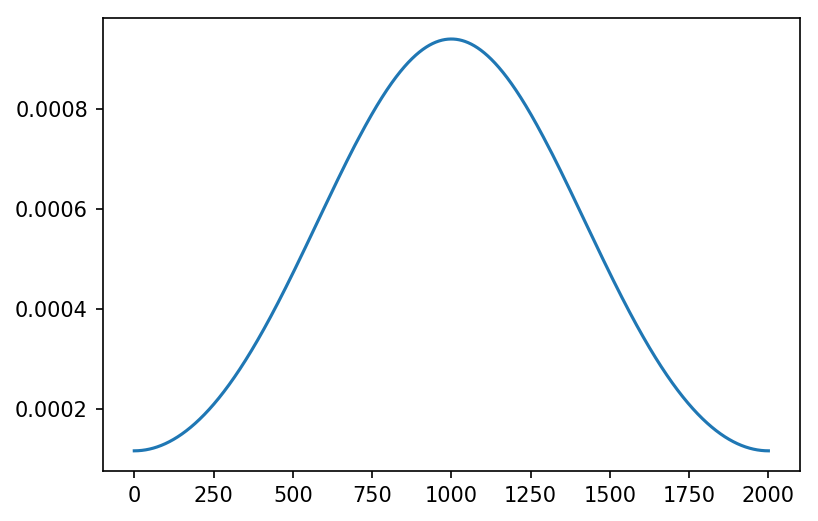

In [926]:
## Make a Gaussian kernel (half-width=500ms). 

x = np.zeros(2001)
x[1000] = 1
g_std = ((config['halfWidth'] * config['samplingRate'])/1000) / (2 * np.sqrt(2 * np.log(2)))
g_win = gaussian_filter(x, g_std)
plt.plot(g_win)
np.nanmean(g_win), np.nanstd(g_win), np.nansum(g_win), g_win.shape, np.nansum(g_win[0:1000]), np.nansum(g_win[1001:]), g_win[1000]
#np.max(g_win)/2, g_win[745:755]

In [931]:
i = 0 # the lfp_mne channel to display

chan = lfp_mne.ch_names[i]
stats.pearsonr(session_spikes[chan]['fr'][0], 
               np.roll(lfp_mne.get_data(picks=[0]).squeeze(), 
                       int(np.random.rand() * len(lfp_mne.get_data(picks=[0]).squeeze()))))

(-0.0010163959182780144, 0.07885115660570412)